# Introducción
El objetivo de este trabajo es hallar el equipo de $N$ pokemons, teniendo en cuenta de que existen $D$ especies de pokemons distintas (se llama así por la base de datos PokDex, utilizada para resolver este problema).

En el juego cada pokemon tiene 5 **estadísticas base** que van de 1 a 255:
- **HP:** Puntos de vida, si llegan a 0 el pokemon muere
- **Ataque:** Daño físico
- **Defensa:** Evita que se reduzca el HP al recibir daño físico
- **Ataque Especial:** Daño especial
- **Daño Especial:** Evita que se reduzca el HP al recibir daño especial
- **Velocidad:** Hace que tu pokemon ataque primero

También cada pokemon tiene uno o dos **tipos elementales**, dependiendo del tipo del ataque y los tipos del defensor, los HP restados se multiplican según lo indicado en la tabla de tipos.

<img src="https://external-preview.redd.it/_e3Jm0hKYHhqcYMYr98RKKYjKY_xl1VNyLyDHoeiLmI.png?width=640&crop=smart&auto=webp&s=3561f9f8fd481697afb57d07b0e1ccf0f0d2cea9" style="width: 400px"/>

<span style="color: red; font-size: small;"># Nota: Para este problema las inmunidades x0 pasab a ser x0.5 así podría evitar infinitos el cálculo y hacer más entendible todo</span>


Para que un equipo pokemon sea bueno, se recomienda que cubra ataque y defienda bien todos los tipos. Se valora muy positivamente tener varios pokemon que sean muy buenos atacando o defendiendo a determinados tipo, aunque sean débiles en otros aspectos se cubren las debilidades entre sí, frente a tener un equipo de pokemons que todos son medianamente buenos en todo, pero no destaquen en nada. Esta propiedad que se quiere recompensar, donde cada pokemon tiene un rol, se denomina **sinergia**.

## Parametrización del problema para el algoritmo genético
Para el algoritmo evolutivo, el **individuo** será el equipo representado con una lista de números, cada elemento representa a un pokemon mediante su identificador en la base de datos. Y cada pokemon es considerado un **gen**.

$$ P = \{p_1, p_2, \ldots, p_N\} $$
$$ \forall p \in P, \; p \in D $$

La **función objetivo** esta formada por otras funciones de puntaje individual, la capacidad ofensiva y defensiva, tanto especial y física, para cada tipo junto a la velocidad. Para tener en cuenta la sinergía explicada anteriormente, para cada puntación individual estadística individual se multiplicará por el número de pokemons con peores puntación más uno (dicha variable se representa como $r$ de ranking).

Para las estadisticas dependientes del tipo, se suman todas para cada tipo y se dividen ente el número de tipos, así cuenta de lo mismo capicadad ofensiva, ofensiva especial, defensiva, defensiva especial y velocidad.

$$ teamScore(P) = 
    \sum_{s=1}^{S}
        \frac{
            \sum_{t=1}^T
                \sum_{r=1}^{N} indScore_{s (r)}(P_{(r)},t) / r
        } T
    + \sum_{r=1}^{N} vel_{(r)}(P_{(r)}) / r
$$

Para el ataque y ataque especial, suponemos que el pokemon siempre atacará con el tipo más efectivo (el que tiene mayor multiplicador), $m(tipo_{atk}, tipo_{def})$ representa el multiplicador de daño.
$$
indScore_1(p,t) = atkScore_1(p,t) = atk(p) \cdot max_{i \in \{1,2\}}( m(type_i,t) )
$$
$$
indScore_2(p,t) = spAtkScore_1(p,t) = spAtk(p) \cdot max_{i \in \{1,2\}}( m(type_i,t) )
$$


La capacidad defensiva tanto por parte física y especial dependen linealmente del HP, por tanto su estadistica de defensa multiplica el HP, no obstante para evitar que tome valores muy altos se calcula la raíz cuadrada posteriormente.
$$
indScore_3(p,t) = defScore(p,t) =
\frac{
    \sqrt{def(p) \cdot hp(p)} 
}{
    m(t, type_1(p)) \cdot m(t,type_2(p))
}
$$
$$
indScore_4(p,t) = spDefScore(p,t) =
\frac{
 \sqrt{spDef(p) \cdot hp(p)} } { m(t, type_1(p)) \cdot m(t,type_2(p)) }
$$


# Implementación de los puntajes de la función objetivo

In [2]:
# Cargar el diccionario del json para los multiplicadores de la tabla de tipos
# typeMult['attack_type']['defensive_type']
import json
with open('type-chart.json') as file:
    typeMult = json.load(file)
types = typeMult.keys()

In [3]:
import pypokedex as dex

def atkScore(pokemon: dex.Pokemon, t_def:str) -> float:
    atk = pokemon.base_stats.attack
    types_atk = pokemon.types

    if len(pokemon.types)<2:
        t_atk = types_atk[0]
        score = atk * typeMult[t_atk][t_def]
    else:
        t1_atk, t2_atk = types_atk
        score = max(typeMult[t1_atk][t_def], typeMult[t2_atk][t_def]) * atk
    
    return score

def spAtkScore(pokemon: dex.Pokemon, t_def:str) -> float:
    atk = pokemon.base_stats.sp_atk
    types_atk = pokemon.types

    if len(pokemon.types)<2:
        t_atk = types_atk[0]
        score = atk * typeMult[t_atk][t_def]
    else:
        t1_atk, t2_atk = types_atk
        score = max(typeMult[t1_atk][t_def], typeMult[t2_atk][t_def]) * atk

    return score

# prueba
pokemon = dex.get(dex=923)
print(atkScore(pokemon,'water'))
print(atkScore(pokemon,'fire'))
print(atkScore(pokemon,'dark'))
print()
print(spAtkScore(pokemon,'water'))
print(spAtkScore(pokemon,'fire'))
print(spAtkScore(pokemon,'dark'))

230
115
230

140
70
140


In [4]:
import math

def defScore(pokemon: dex.Pokemon, t_atk:str) -> float:
    defe = pokemon.base_stats.defense
    hp = pokemon.base_stats.hp
    types_def = pokemon.types

    if len(pokemon.types)<2:
        t_def = types_def[0]
        score = math.sqrt(defe*hp) / typeMult[t_atk][t_def]
    else:
        t1_def, t2_def = types_def
        score = math.sqrt(defe*hp) / (typeMult[t_atk][t1_def] * typeMult[t_atk][t2_def])
    
    return score

def spDefScore(pokemon: dex.Pokemon, t_atk:str) -> float:
    defe = pokemon.base_stats.sp_def
    hp = pokemon.base_stats.hp
    types_def = pokemon.types

    if len(pokemon.types)<2:
        t_def = types_def[0]
        score = math.sqrt(defe*hp) / typeMult[t_atk][t_def]
    else:
        t1_def, t2_def = types_def
        score = math.sqrt(defe*hp) / (typeMult[t_atk][t1_def] * typeMult[t_atk][t2_def])
    
    return score

# prueba
pokemon = dex.get(dex=134)
print(defScore(pokemon,'water'))
print(defScore(pokemon,'fire'))
print(defScore(pokemon,'dark'))
print()
print(spDefScore(pokemon,'water'))
print(spDefScore(pokemon,'fire'))
print(spDefScore(pokemon,'dark'))

176.63521732655693
176.63521732655693
88.31760866327846

222.26110770892868
222.26110770892868
111.13055385446434


In [5]:
import queue as q

def teamScore(team: list[int]) -> float:
    score = 0.0
    minq_vel = q.PriorityQueue()

    T = len(types)
    invT = 1/T

    minq_atkScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]
    minq_spAtkScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]
    minq_defScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]
    minq_spDefScores:list[q.PriorityQueue] = [q.PriorityQueue() for _ in range(T)]

    
    for pokemon_id in team:
        pokemon = dex.get(dex=pokemon_id)

        i=0
        for type in types:
            minq_atkScores[i].put(atkScore(pokemon, type)); minq_spAtkScores[i].put(spAtkScore(pokemon, type))
            minq_defScores[i].put(defScore(pokemon, type)); minq_spDefScores[i].put(spDefScore(pokemon, type))
            i+=1
        minq_vel.put(pokemon.base_stats.speed)

    for rank in range(len(team), 0, -1):
        score_this_rank = 0.0
        for i in range(0,T):
            score_this_rank += (minq_atkScores[i].get() + minq_spAtkScores[i].get() + minq_defScores[i].get() + minq_spDefScores[i].get()) * invT
        score_this_rank *= invT
        score_this_rank += minq_vel.get()/rank/rank
        score_this_rank /= rank
        score += score_this_rank
    return score

test_team = [150, 150, 150,  150, 150, 150]
print(f"teamScore = {teamScore(test_team)}")

teamScore = 218.99671457474884


## Comprobación de que los puntajes funcionan correctamente

Para poder visualizar mejor el equipo que se ha formado, se va a definir una función que nos otorga información sobre un determinado equipo.

In [6]:
import pypokedex
from io import BytesIO
from IPython.display import display, HTML
import base64
import random
import matplotlib.pyplot as plt

def showTeam (pokemons_ids):

    print(f"teamScore = {teamScore(pokemons_ids)}")


    # Mostrar la información en una tabla
    html = ''' 
    <table border='1'>
        <tr>
            <th>#ID</th>
            <th>Imagen</th>
            <th>Nombre</th>
            <th>Tipo</th>
            <th>Estadísticas </th>
            <th>Atacando frente a tipos</th>
            <th>Defendiendo frente a tipos </th>
        </tr> 
    '''

    # Función para mapear el valor de la estadística a un color
    def get_color(value):
        if value <= 100:
            r = int(255 * (1 - value / 100))
            g = int(255 * (value / 100))
            b = 0
        else:
            r = 0
            g = 255 #int(255 * (1 - (value - 100) / 155))
            b = int(255 * ((value - 100) / 155) * 1.5)
            if b > 255:
                b = 255  # Asegurarse de que el valor no exceda 255
        return f'#{r:02x}{g:02x}{b:02x}'

    # Obtener la información de los Pokémon
    for pokemon_id in pokemons_ids:
        pokemon = pypokedex.get(dex=pokemon_id)
        image_url = pokemon.sprites.front.get('default')
        stats = pokemon.base_stats

        # Crear el gráfico de barras con las estadísticas
        values = [stats.hp, stats.attack, stats.defense, stats.sp_atk, stats.sp_def, stats.speed]
        colors = [get_color(value) for value in values]
        fig, ax = plt.subplots()
        ax.bar(['HP', 'Atk', 'Def', 'Sp.Atk', 'Sp.Def', 'Speed'], values, color=colors)
        
        # Guardar el gráfico como imagen en memoria
        buf = BytesIO()
        plt.savefig(buf, format='png')
        plt.close(fig)
        buf.seek(0)
        img_base64 = base64.b64encode(buf.read()).decode('utf-8')

        # Obtener tabla de tipos de ataque
        good_attacking = []
        bad_attacking = []

        for my_type in pokemon.types:
            for other_type in types:
                if typeMult[my_type][other_type] == 2:
                    good_attacking.append(other_type)
                elif typeMult[my_type][other_type] == 0.5:
                    bad_attacking.append(other_type)

        bad_attacking = [item for item in bad_attacking if item not in good_attacking]
        
        # Obtener tabla de tipos defendiendo
        very_good_defending = []
        good_defending = []
        neutral_defending = []
        bad_defending = []
        very_bad_defending = []

        arrayByMult = {
            25: very_good_defending,
            50: good_defending,
            100: neutral_defending,
            200: bad_defending,
            400: very_bad_defending
        }

        for other_type in types:
            mult1 = typeMult[other_type][pokemon.types[0]]
            mult2 = 1 if len(pokemon.types)<2 else typeMult[other_type][pokemon.types[1]]
            arrayByMult[int(mult1*mult2*100)].append(other_type)

        # Imprimir tabla con la información previamente recopilada
        html += "<tr>"
        html += f"<td>#{pokemon_id}</td>"
        html += f"<td><img src='{image_url}' width='150'></td>"
        html += f"<td><b>{pokemon.name.capitalize()}</b></td>"
        html += f"<td>{pokemon.types}</td>"
        html += f"<td><img src='data:image/png;base64,{img_base64}' width='300'></td>"
        html += f"<td>x2: {good_attacking}<br>x0.5: {bad_attacking}</td>"
        html += f"<td>/4: {very_good_defending}<br>/2: {good_defending}<br>/0.5: {bad_defending} <br>/0.25: {very_bad_defending}</td>"
        html += "</tr>"

    html += "</table>"

    display(HTML(html))

Ahora vamos a probar que el nuestra **función objetivo** funciona, para un equipo de un pokemon relativamente poderoso en todo, comparado con un equipo donde cada miembro esta especializado en atacar o defender determinados tipos. Si funciona correctamente, el segundo equipo, que tiene mayor sinergía debe de tener mayor puntuación.

teamScore = 206.3535185185185


#ID,Imagen,Nombre,Tipo,Estadísticas,Atacando frente a tipos,Defendiendo frente a tipos
#493,,Arceus,['normal'],,"x2: []x0.5: ['rock', 'ghost', 'steel']",/4: []/2: ['ghost']/0.5: ['fighting'] /0.25: []
#493,,Arceus,['normal'],,"x2: []x0.5: ['rock', 'ghost', 'steel']",/4: []/2: ['ghost']/0.5: ['fighting'] /0.25: []
#493,,Arceus,['normal'],,"x2: []x0.5: ['rock', 'ghost', 'steel']",/4: []/2: ['ghost']/0.5: ['fighting'] /0.25: []
#493,,Arceus,['normal'],,"x2: []x0.5: ['rock', 'ghost', 'steel']",/4: []/2: ['ghost']/0.5: ['fighting'] /0.25: []
#493,,Arceus,['normal'],,"x2: []x0.5: ['rock', 'ghost', 'steel']",/4: []/2: ['ghost']/0.5: ['fighting'] /0.25: []
#493,,Arceus,['normal'],,"x2: []x0.5: ['rock', 'ghost', 'steel']",/4: []/2: ['ghost']/0.5: ['fighting'] /0.25: []

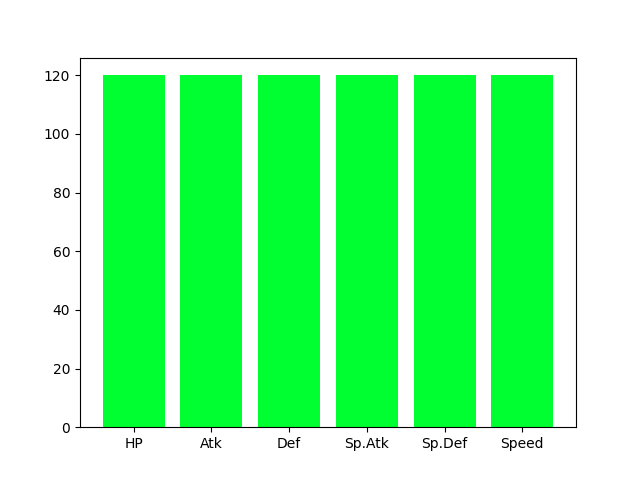
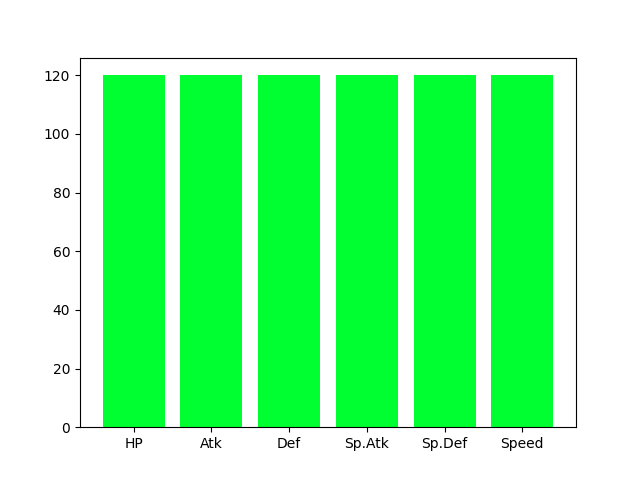
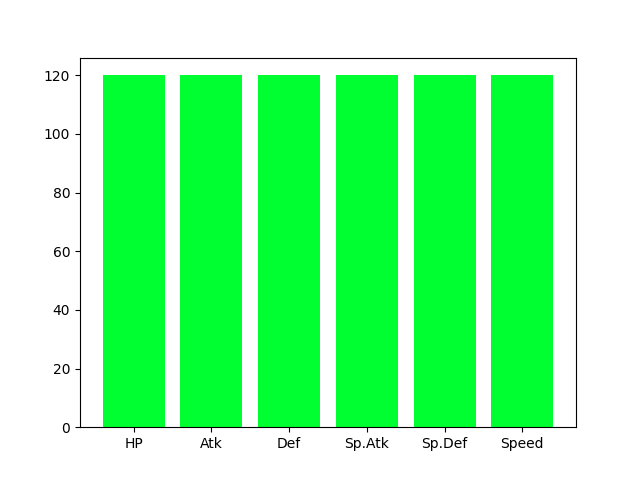
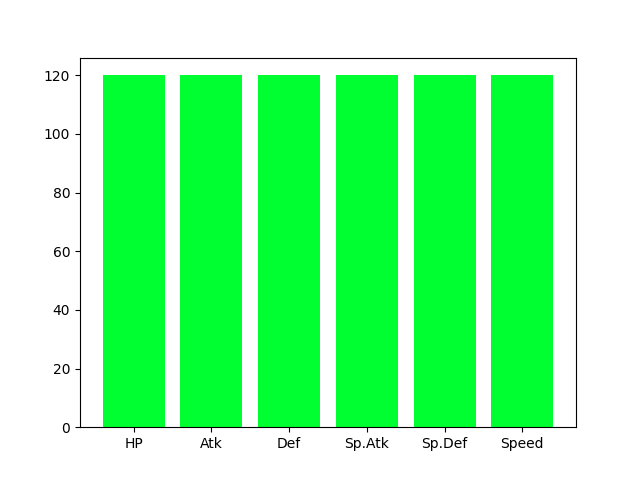
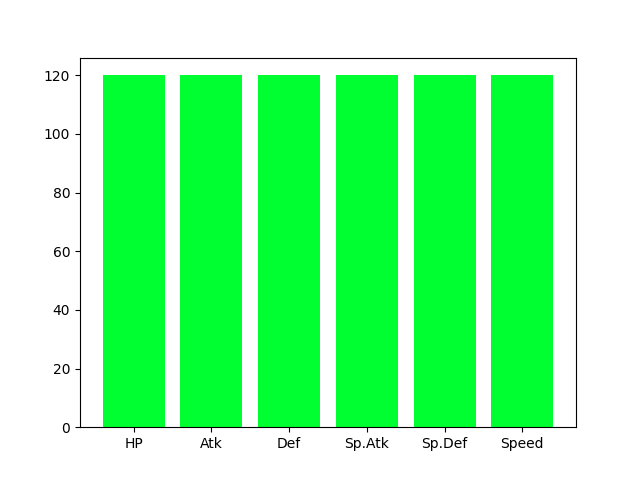
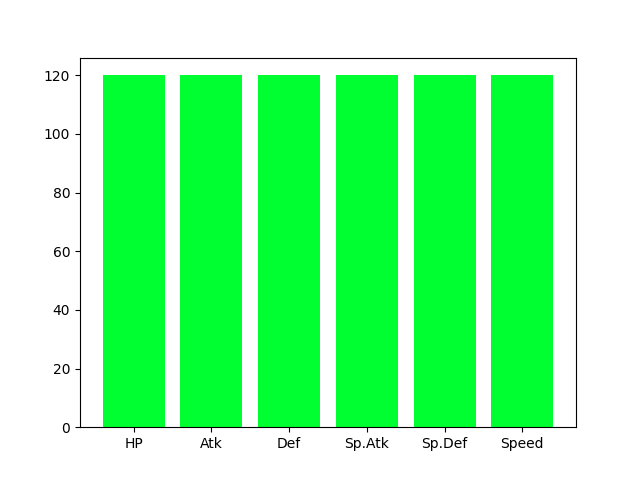

In [7]:
arceus_team = [493, 493, 493, 493, 493, 493]
showTeam(arceus_team)

teamScore = 215.06036951153936


#ID,Imagen,Nombre,Tipo,Estadísticas,Atacando frente a tipos,Defendiendo frente a tipos
#134,,Vaporeon,['water'],,"x2: ['fire', 'ground', 'rock']x0.5: ['water', 'grass', 'dragon']","/4: []/2: ['fire', 'water', 'ice', 'steel']/0.5: ['electric', 'grass'] /0.25: []"
#135,,Jolteon,['electric'],,"x2: ['water', 'flying']x0.5: ['electric', 'grass', 'ground', 'dragon']","/4: []/2: ['electric', 'flying', 'steel']/0.5: ['ground'] /0.25: []"
#136,,Flareon,['fire'],,"x2: ['grass', 'ice', 'bug', 'steel']x0.5: ['fire', 'water', 'rock', 'dragon']","/4: []/2: ['fire', 'grass', 'ice', 'bug', 'steel', 'fairy']/0.5: ['water', 'ground', 'rock'] /0.25: []"
#196,,Espeon,['psychic'],,"x2: ['fighting', 'poison']x0.5: ['psychic', 'dark', 'steel']","/4: []/2: ['fighting', 'psychic']/0.5: ['bug', 'ghost', 'dark'] /0.25: []"
#197,,Umbreon,['dark'],,"x2: ['psychic', 'ghost']x0.5: ['fighting', 'dark', 'steel', 'fairy']","/4: []/2: ['psychic', 'ghost', 'dark']/0.5: ['fighting', 'bug', 'fairy'] /0.25: []"
#700,,Sylveon,['fairy'],,"x2: ['fighting', 'dragon', 'dark']x0.5: ['fire', 'poison', 'steel']","/4: []/2: ['fighting', 'bug', 'dragon', 'dark']/0.5: ['steel'] /0.25: []"

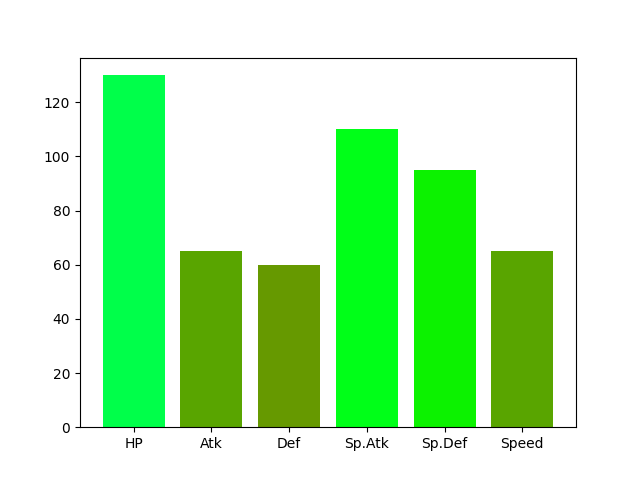
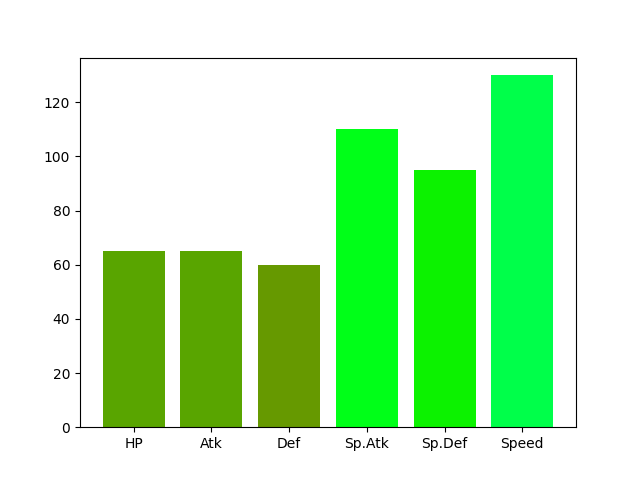
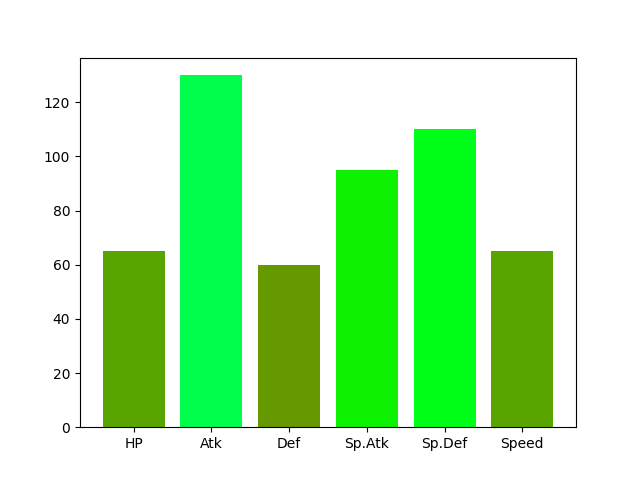
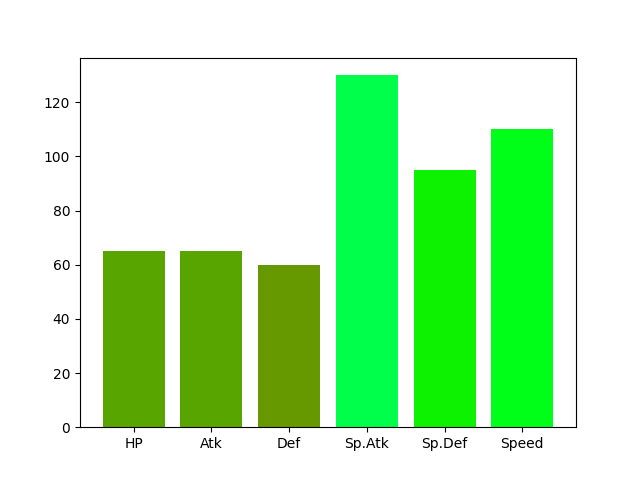
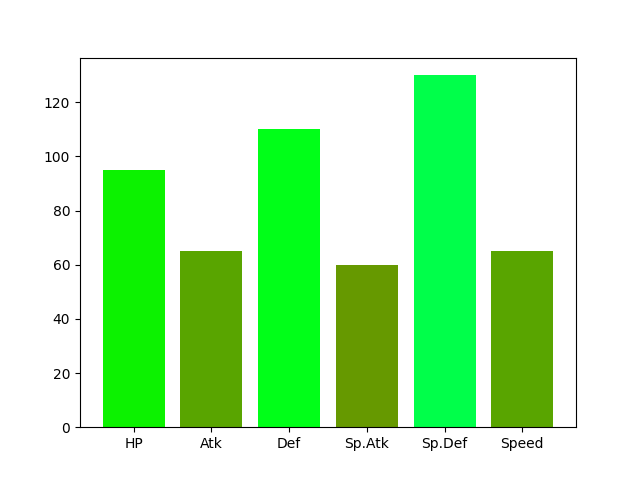
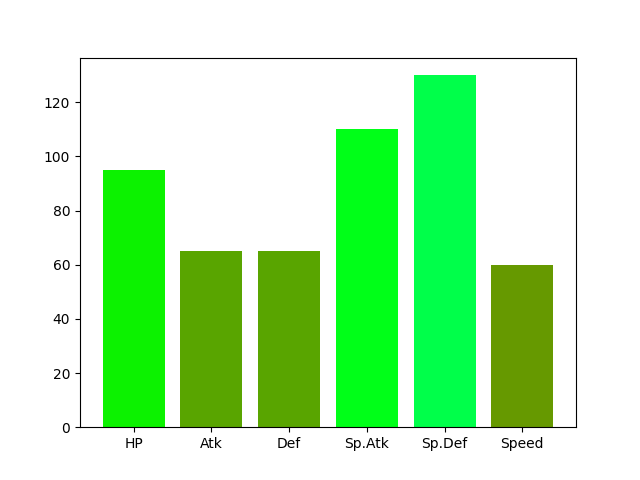

In [8]:
balanced_eevee_team = [134, 135, 136, 196, 197, 700]  # Vaporeon, Jolteon, Flareon, Espeon, Umbreon, Sylveon
showTeam(balanced_eevee_team)

# Implementación del algoritmo genético

Para implementar el algoritmo genético, se ha escogido pyhton por la capacidad que proporciona definir métodos que se pueden reescribir posteriormente con facilidad. Esto nos permitirá ir cambiando entre diferentes estrategias a la hora de manipular la población. Además, también permite instalar librerías, hacer plots y usarse en jupyter con facilidad.

No obstante, como contraparte, python es un lenguaje lento, pero tiene librerías para hacer cálculos paralelos fe forma eficiente y si es necesario se pueden integrar otros programas en C/C++

Primero implemento el algoritmo con funciones vacías, para posteriormente definirlas. Al algoritmo de las transparencias he decidido añadirle un método ambiente, que cambia los otros parámetros en función del estado del problema.

In [9]:

# Iteración del algoritmo genetico
def genetic_it(population:list[list[int]]) -> None:
    select(population)
    reproduce(population)
    mutate(population)
    remove(population)
    enviorment()

# Definir más tarde
def select(population):pass
def reproduce(population):pass
def mutate(population):pass
def remove(population):pass
def enviorment():pass


Lo mismo hago con el bucle con la condición de salida. Pero en este caso vemos como se utilizan variables globales para que puedan acceder otras funciones sin tener que cambiar el código de llamada o de la definición, e ir podiendo variar el parámetro a tiempo de ejecución.

En el caso de iterations se utiliza en la condición de parada posteriormente.

In [10]:
import datetime
from datetime import datetime, timedelta

class Experiment:
    def __init__(self):
        self.teams = []
        self.scores = []
        self.times = []
        self.iterations = []
    
    def add(self) -> None:
        global best_score
        global best_team
        global time_start
        global iterations

        if not self.scores or self.scores[-1]<best_score:
            self.teams.append(best_team[:])
            self.scores.append(best_score)
            self.times.append((datetime.now() - time_start).total_seconds()) 
            self.iterations.append(iterations)
    
    def showTable(self) -> None:
        table_html = "<table><tr><th>Teams</th><th>Scores</th><th>Times</th><th>Iterations</th></tr>"
        for team, score, time, iteration in zip(self.teams, self.scores, self.times, self.iterations):
            team_images = ''.join([f'<img src="https://raw.githubusercontent.com/PokeAPI/sprites/master/sprites/pokemon/{pokemon_id}.png" width="50" height="50">' for pokemon_id in team])
            table_html += f"<tr><td>{team_images}</td><td>{score}</td><td>{time}</td><td>{iteration}</td></tr>"
        table_html += "</table>"
        display(HTML(table_html))
        


# Bucle de ejecución
def run_genetic(population) -> Experiment:
    global iterations
    iterations = 0

    global best_score
    best_score = -1.0

    global time_start
    time_start = datetime.now()

    global stop_condition

    experiment = Experiment()

    while stop_condition():
        genetic_it(population)
        iterations += 1
        experiment.add()
        
    experiment.add()

    return experiment


# Definir más tarde
def stop_condition():pass

## Experimento 1

El primer experimento se va a usar un método muy sencillo para usarlo como comparativa respecto a otros métodos más complejos. En primer lugar, cada equipo va se va a copiar varias veces y se va meter un pokemon al azar. Después sobreviven solo los que tengan mejor función objetivo. 

La reproducción será similar a la de un virus o una celula en la naturelaza.

In [11]:
import random
import copy

D = 1024    # especies pokemon
N = 6       # miembros por equipo      

def cloning(population:list[list[int]]):
    global copies   # clones de cada individuo

    for i in range(len(population)):
        for _ in range(copies):
            population.append(copy.copy(population[i]))


def mutate_random_rate(population:list[list[int]]):
    global mutation_rate   #  ratio de que un gen mute

    global best_team
    
    for team in population:
        if id(team) != id(best_team):
            for i in range(N):                
                if mutation_rate >= random.uniform(0, 1.0):
                    team[i] = random.randint(1, D)

    


best_team = [1,1,1, 1,1,1]
best_score = -1.0
def survive_the_best(population):
    global survivors   # número de supervivientes que quedan al final de la iteración

    global best_score
    global best_team


    maxq_teams = q.PriorityQueue()

    for team in population:
        ts = teamScore(team)
        if ts > best_score:
            best_team = team
            best_score = ts
        maxq_teams.put((-ts, team))
    
    population.clear()
    for i in range(min(survivors, maxq_teams.qsize())):
        _,survivor = maxq_teams.get()
        population.append(survivor)



population = [[1,1,1, 1,1,1]]

copies = 5
cloning(population)
print(population)
print("end cloning")

mutation_rate = 0.5
mutate_random_rate(population)
print(population)
print("end mutation")

survivors = 2
survive_the_best(population)
print(population)
print("end removing")


[[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]
end cloning
[[1, 1, 1, 654, 1, 501], [915, 984, 1, 336, 1, 1], [1, 91, 1, 1, 567, 432], [1, 1, 301, 687, 1, 671], [1, 375, 1, 1, 1, 339], [625, 1, 1, 954, 1, 163]]
end mutation
[[1, 91, 1, 1, 567, 432], [1, 1, 301, 687, 1, 671]]
end removing


In [12]:
from datetime import datetime, timedelta
import time

# Función inicial (solo se ejecuta en la primera iteración)
def stop_by_time() -> bool:
    global seconds

    global max_time
    max_time = datetime.now() + timedelta(seconds=seconds)

    global stop_condition
    stop_condition = check_stop_by_time

    return True


# Función de parámetro inicializado (se ejecuta el resto de iteraciones)
def check_stop_by_time() -> bool:
    global max_time

    if datetime.now() > max_time:
        global stop_condition
        stop_condition = stop_by_time
        return False

    return True


stop_condition = stop_by_time

seconds = 3
while stop_condition():
    time.sleep(1)
    print("ejecutando...")

ejecutando...
ejecutando...
ejecutando...


Ahora teniendo las funciones ya definidas, escribo los parámetros de mi primer experimento

In [19]:
reproduce = cloning
copies = 5

mutate = mutate_random_rate
mutatation_rate = 0.2

remove = survive_the_best
survivors = 5

N = 6
D = 1024

population = [[1,1,1, 1,1,1]]


In [20]:
#population = [[1,1,1, 1,1,1]]
genetic_it(population)
population

[[787, 92, 1, 373, 197, 212],
 [1, 763, 493, 1, 1, 1],
 [455, 162, 1, 805, 1, 255],
 [233, 1, 690, 1, 110, 876],
 [812, 1, 1, 1, 223, 1]]

Teams,Scores,Times,Iterations
,175.6867682188461,0.005509,1
,193.02687599729813,0.034896,2
,240.34851275402832,0.062254,3
,256.05027223491135,0.090534,4
,284.6109590905943,0.204394,8
,288.85538124383646,0.232937,9
,295.4189012626412,0.260519,10
,298.67237755796725,0.288654,11
,300.6669857550937,0.456624,17
,304.09389899554947,0.484507,18


teamScore = 326.5001865550064


#ID,Imagen,Nombre,Tipo,Estadísticas,Atacando frente a tipos,Defendiendo frente a tipos
#483,,Dialga,"['steel', 'dragon']",,"x2: ['ice', 'rock', 'fairy', 'dragon']x0.5: ['fire', 'water', 'electric', 'steel', 'steel']","/4: ['grass']/2: ['normal', 'water', 'electric', 'poison', 'flying', 'psychic', 'bug', 'rock', 'ghost', 'dark', 'steel']/0.5: ['fighting', 'ground'] /0.25: []"
#721,,Volcanion,"['fire', 'water']",,"x2: ['grass', 'ice', 'bug', 'steel', 'fire', 'ground', 'rock']x0.5: ['water', 'dragon', 'water', 'dragon']","/4: ['fire', 'ice', 'steel']/2: ['bug', 'fairy']/0.5: ['electric', 'ground', 'rock'] /0.25: []"
#894,,Regieleki,['electric'],,"x2: ['water', 'flying']x0.5: ['electric', 'grass', 'ground', 'dragon']","/4: []/2: ['electric', 'flying', 'steel']/0.5: ['ground'] /0.25: []"
#795,,Pheromosa,"['bug', 'fighting']",,"x2: ['grass', 'psychic', 'dark', 'normal', 'ice', 'rock', 'dark', 'steel']x0.5: ['fire', 'fighting', 'poison', 'flying', 'ghost', 'fairy', 'poison', 'flying', 'bug', 'ghost', 'fairy']","/4: []/2: ['grass', 'fighting', 'ground', 'bug', 'dark']/0.5: ['fire', 'psychic', 'fairy'] /0.25: ['flying']"
#791,,Solgaleo,"['psychic', 'steel']",,"x2: ['fighting', 'poison', 'ice', 'rock', 'fairy']x0.5: ['psychic', 'dark', 'steel', 'fire', 'water', 'electric', 'steel']","/4: ['psychic']/2: ['normal', 'grass', 'ice', 'poison', 'flying', 'rock', 'dragon', 'steel', 'fairy']/0.5: ['fire', 'ground'] /0.25: []"
#805,,Stakataka,"['rock', 'steel']",,"x2: ['fire', 'ice', 'flying', 'bug', 'ice', 'rock', 'fairy']x0.5: ['fighting', 'ground', 'steel', 'water', 'electric', 'steel']","/4: ['normal', 'poison', 'flying']/2: ['ice', 'psychic', 'bug', 'rock', 'ghost', 'dragon', 'dark', 'fairy']/0.5: ['water'] /0.25: ['fighting', 'ground']"

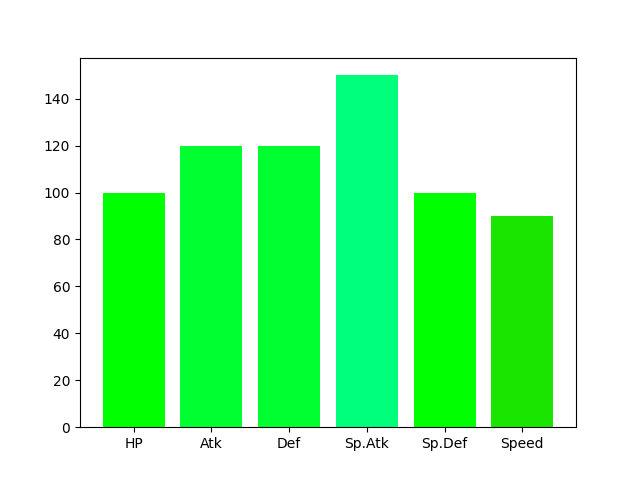
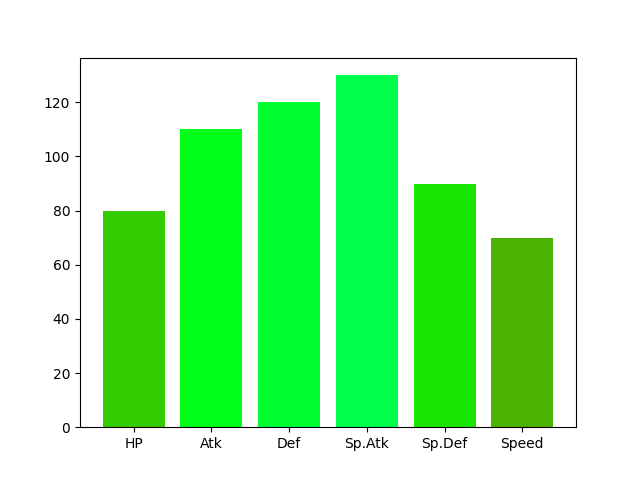
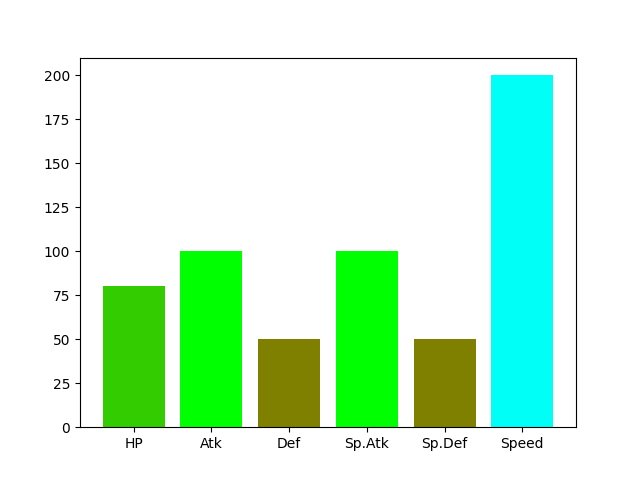
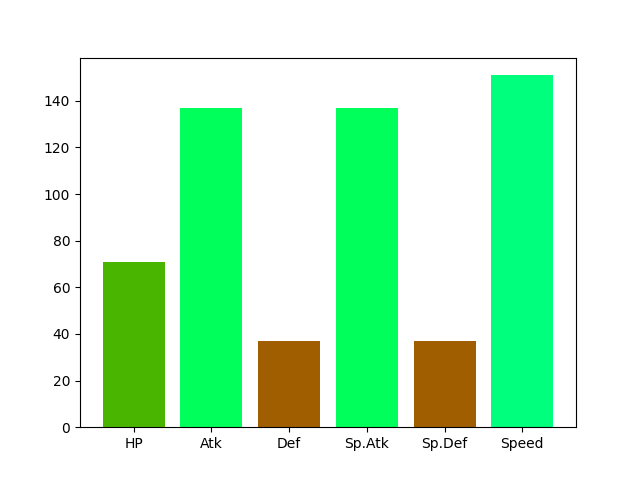
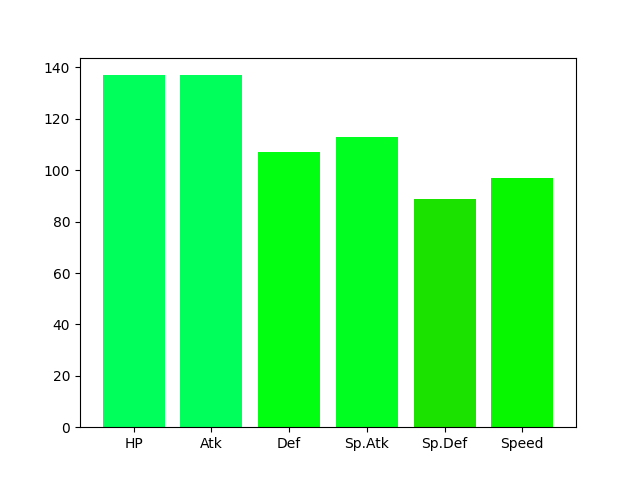
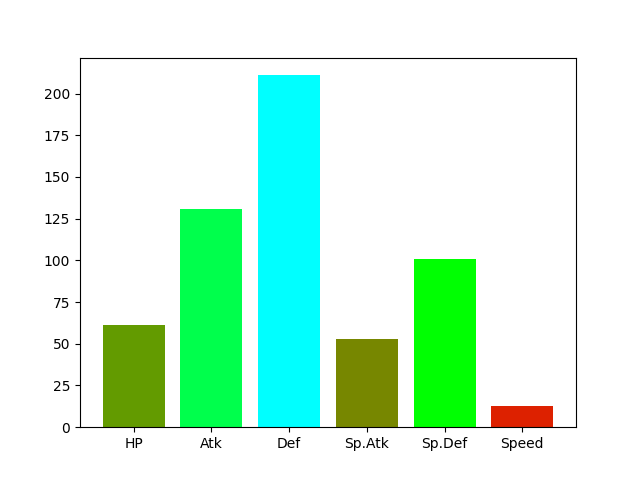

Teams,Scores,Times,Iterations
,203.50286618130946,0.009359,1
,220.49839559450987,0.042315,2
,222.6273796748457,0.072729,3
,224.29916377401034,0.103443,4
,239.8620653026498,0.136652,5
,247.43928999133618,0.169879,6
,250.59609137879437,0.204918,7
,290.1347239589518,0.240267,8
,290.4270125484236,0.281304,9
,300.76269905834937,0.314112,10


teamScore = 323.3168764687458


#ID,Imagen,Nombre,Tipo,Estadísticas,Atacando frente a tipos,Defendiendo frente a tipos
#894,,Regieleki,['electric'],,"x2: ['water', 'flying']x0.5: ['electric', 'grass', 'ground', 'dragon']","/4: []/2: ['electric', 'flying', 'steel']/0.5: ['ground'] /0.25: []"
#983,,Kingambit,"['dark', 'steel']",,"x2: ['psychic', 'ghost', 'ice', 'rock', 'fairy']x0.5: ['fighting', 'dark', 'steel', 'fire', 'water', 'electric', 'steel']","/4: ['psychic', 'ghost', 'dark']/2: ['normal', 'grass', 'ice', 'poison', 'flying', 'rock', 'dragon', 'steel']/0.5: ['fire', 'ground'] /0.25: ['fighting']"
#795,,Pheromosa,"['bug', 'fighting']",,"x2: ['grass', 'psychic', 'dark', 'normal', 'ice', 'rock', 'dark', 'steel']x0.5: ['fire', 'fighting', 'poison', 'flying', 'ghost', 'fairy', 'poison', 'flying', 'bug', 'ghost', 'fairy']","/4: []/2: ['grass', 'fighting', 'ground', 'bug', 'dark']/0.5: ['fire', 'psychic', 'fairy'] /0.25: ['flying']"
#208,,Steelix,"['steel', 'ground']",,"x2: ['ice', 'rock', 'fairy', 'fire', 'electric', 'poison', 'rock', 'steel']x0.5: ['water', 'grass', 'flying', 'bug']","/4: ['poison', 'rock']/2: ['normal', 'electric', 'flying', 'psychic', 'bug', 'ghost', 'dragon', 'dark', 'steel', 'fairy']/0.5: ['fire', 'water', 'fighting', 'ground'] /0.25: []"
#484,,Palkia,"['water', 'dragon']",,"x2: ['fire', 'ground', 'rock', 'dragon']x0.5: ['water', 'grass', 'steel', 'fairy']","/4: ['fire', 'water']/2: ['steel']/0.5: ['dragon', 'fairy'] /0.25: []"
#643,,Reshiram,"['dragon', 'fire']",,"x2: ['dragon', 'grass', 'ice', 'bug', 'steel']x0.5: ['fairy', 'fire', 'water', 'rock']","/4: ['fire', 'grass']/2: ['electric', 'bug', 'steel']/0.5: ['ground', 'rock', 'dragon'] /0.25: []"

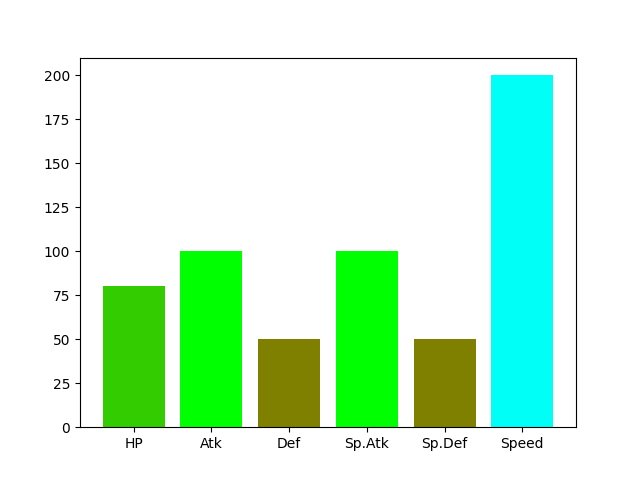
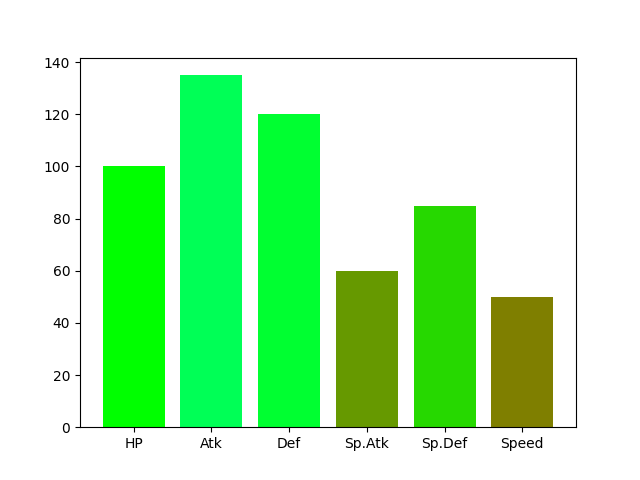
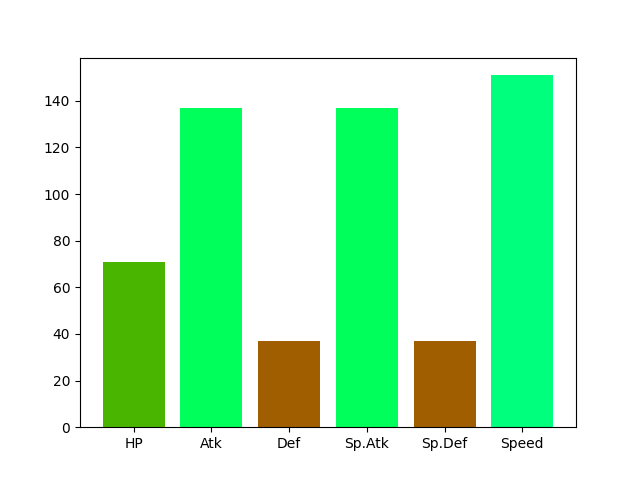
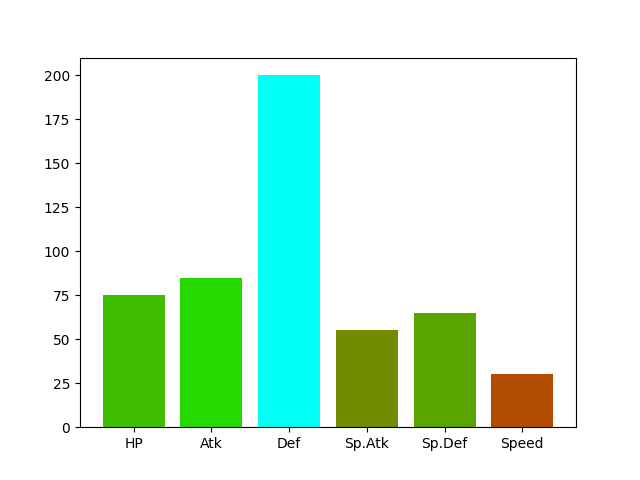
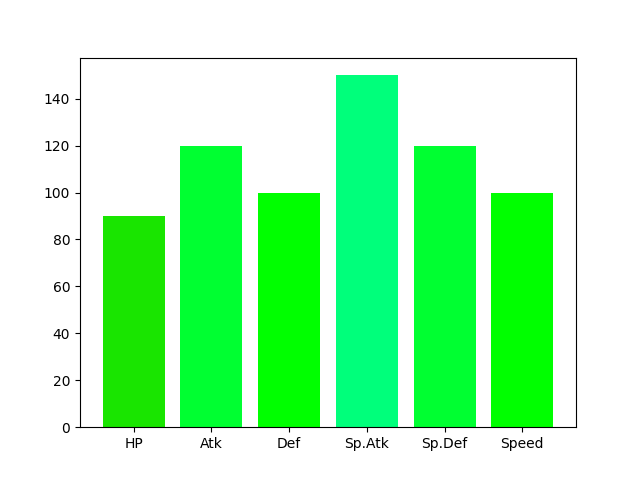
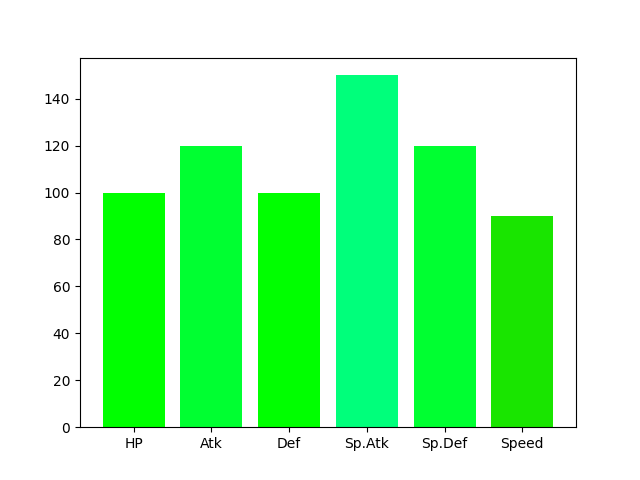

Teams,Scores,Times,Iterations
,199.65217519416393,0.00644,1
,225.40821329905006,0.042865,2
,235.46372102553943,0.077436,3
,244.15361564130527,0.110715,4
,247.63358508751145,0.147294,5
,252.47036117068424,0.193051,6
,253.04793046846513,0.234606,7
,264.276680218984,0.31811,9
,267.1588164224868,0.399077,11
,270.1132505594245,0.47285,13


teamScore = 326.14814996293217


#ID,Imagen,Nombre,Tipo,Estadísticas,Atacando frente a tipos,Defendiendo frente a tipos
#795,,Pheromosa,"['bug', 'fighting']",,"x2: ['grass', 'psychic', 'dark', 'normal', 'ice', 'rock', 'dark', 'steel']x0.5: ['fire', 'fighting', 'poison', 'flying', 'ghost', 'fairy', 'poison', 'flying', 'bug', 'ghost', 'fairy']","/4: []/2: ['grass', 'fighting', 'ground', 'bug', 'dark']/0.5: ['fire', 'psychic', 'fairy'] /0.25: ['flying']"
#894,,Regieleki,['electric'],,"x2: ['water', 'flying']x0.5: ['electric', 'grass', 'ground', 'dragon']","/4: []/2: ['electric', 'flying', 'steel']/0.5: ['ground'] /0.25: []"
#983,,Kingambit,"['dark', 'steel']",,"x2: ['psychic', 'ghost', 'ice', 'rock', 'fairy']x0.5: ['fighting', 'dark', 'steel', 'fire', 'water', 'electric', 'steel']","/4: ['psychic', 'ghost', 'dark']/2: ['normal', 'grass', 'ice', 'poison', 'flying', 'rock', 'dragon', 'steel']/0.5: ['fire', 'ground'] /0.25: ['fighting']"
#890,,Eternatus,"['poison', 'dragon']",,"x2: ['grass', 'dragon']x0.5: ['poison', 'ground', 'rock', 'ghost', 'steel', 'steel', 'fairy']","/4: ['grass']/2: ['fire', 'water', 'electric', 'fighting', 'poison', 'bug']/0.5: ['ice', 'ground', 'psychic', 'dragon'] /0.25: []"
#801,,Magearna,"['steel', 'fairy']",,"x2: ['ice', 'rock', 'fairy', 'fighting', 'dragon', 'dark']x0.5: ['fire', 'water', 'electric', 'steel', 'fire', 'poison', 'steel']","/4: ['bug', 'dragon', 'dark']/2: ['normal', 'grass', 'ice', 'poison', 'flying', 'psychic', 'rock', 'ghost', 'fairy']/0.5: ['fire', 'ground'] /0.25: []"
#721,,Volcanion,"['fire', 'water']",,"x2: ['grass', 'ice', 'bug', 'steel', 'fire', 'ground', 'rock']x0.5: ['water', 'dragon', 'water', 'dragon']","/4: ['fire', 'ice', 'steel']/2: ['bug', 'fairy']/0.5: ['electric', 'ground', 'rock'] /0.25: []"

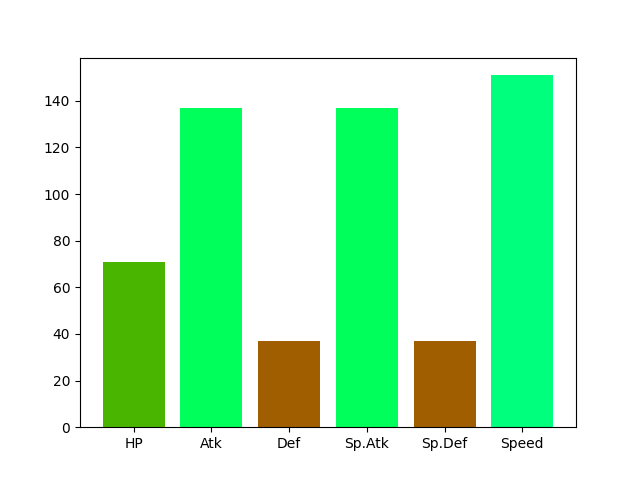
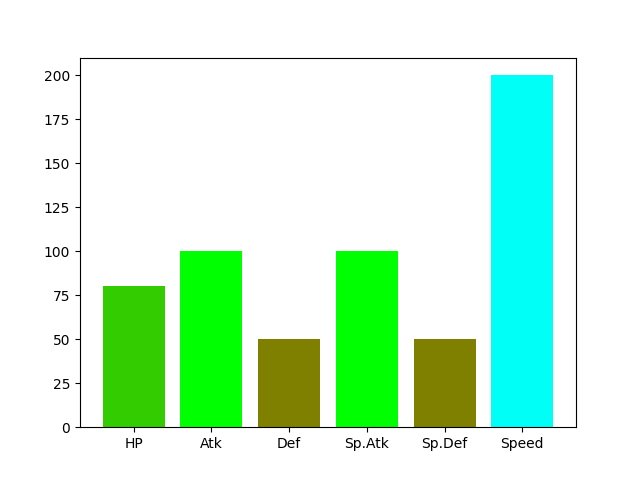
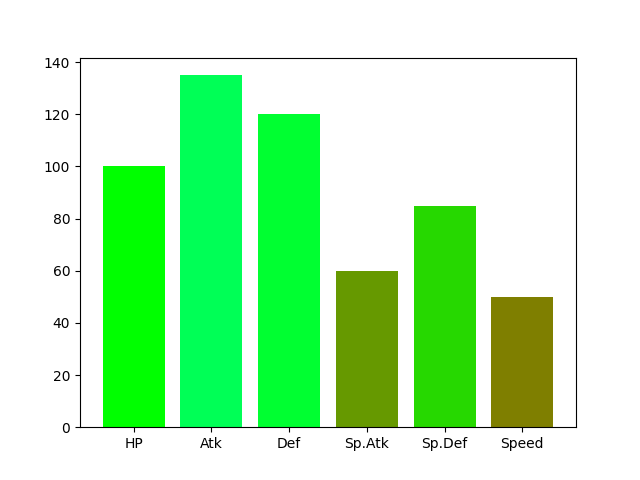
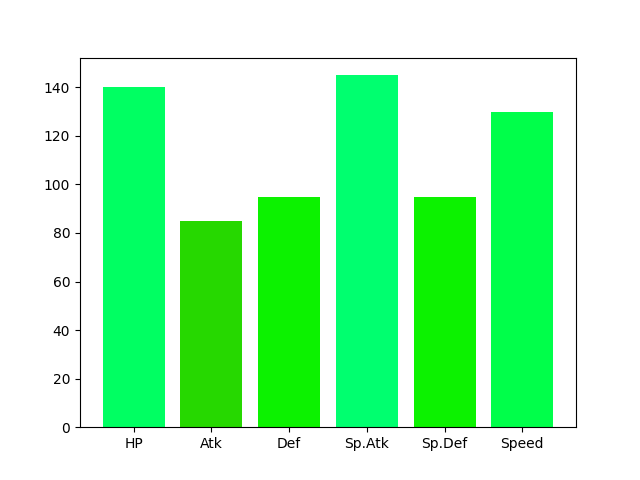
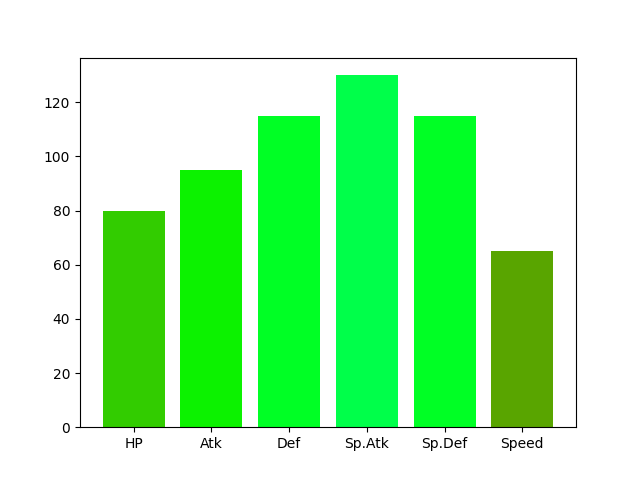
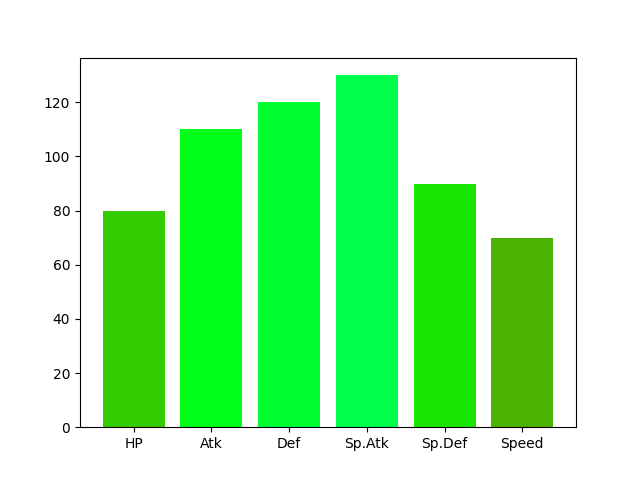

In [25]:
stop_condition = stop_by_time
seconds = 30

N=6
population = [[1 for _ in range(6)]]
experiment = run_genetic(population)
experiment.showTable()
showTeam(best_team)

population = [[500 for _ in range(6)]]
experiment2 = run_genetic(population)
experiment2.showTable()
showTeam(best_team)

population = [[1000 for _ in range(6)]]
experiment3 = run_genetic(population)
experiment3.showTable()
showTeam(best_team)

Text(0, 0.5, 'Score')

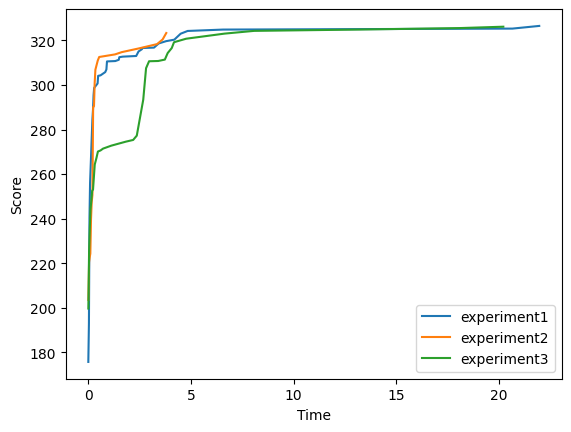

In [26]:
plt.plot(experiment.times, experiment.scores, label="experiment1")
plt.plot(experiment2.times, experiment2.scores, label="experiment2")
plt.plot(experiment3.times, experiment3.scores, label="experiment3")
plt.legend()
plt.xlabel('Time')
plt.ylabel('Score')

Como podemos observar en muy poco tiempo en las primeras iteraciones, la mejora rápidamente se dispara a cerca de 320, y posteriormente se queda le cuesta muchísimo incrementar el valor, probando con diversas poblaciones inicales. El estancamiento de la mejora, se debe a varios factores

Este algoritmo puede ser una buena forma de incializar el algoritmo, pero posteriormente sería mejor hacer cambios más precisos a la población.

In [51]:
reproduce = cloning
copies = 5

mutate = mutate_random_rate
mutatation_rate = 0.2

remove = survive_the_best
survivors = 5

stop_condition = stop_by_time
seconds = 30

N = 6
D = 1024

population = [[1,1,1, 1,1,1]]
run_genetic(population)
experiment.showTable()
print(population)

Teams,Scores,Times,Iterations
,175.6867682188461,0.005509,1
,193.02687599729813,0.034896,2
,240.34851275402832,0.062254,3
,256.05027223491135,0.090534,4
,284.6109590905943,0.204394,8
,288.85538124383646,0.232937,9
,295.4189012626412,0.260519,10
,298.67237755796725,0.288654,11
,300.6669857550937,0.456624,17
,304.09389899554947,0.484507,18


[[894, 485, 791, 483, 1008, 990], [894, 485, 626, 483, 1008, 527], [894, 445, 32, 483, 1008, 990], [894, 485, 791, 483, 25, 441], [894, 4, 791, 606, 1008, 990]]


teamScore = 309.4852415833619


#ID,Imagen,Nombre,Tipo,Estadísticas,Atacando frente a tipos,Defendiendo frente a tipos
#894,,Regieleki,['electric'],,"x2: ['water', 'flying']x0.5: ['electric', 'grass', 'ground', 'dragon']","/4: []/2: ['electric', 'flying', 'steel']/0.5: ['ground'] /0.25: []"
#485,,Heatran,"['fire', 'steel']",,"x2: ['grass', 'ice', 'bug', 'steel', 'ice', 'rock', 'fairy']x0.5: ['fire', 'water', 'dragon', 'fire', 'water', 'electric']","/4: ['grass', 'ice', 'bug', 'steel', 'fairy']/2: ['normal', 'poison', 'flying', 'psychic', 'ghost', 'dragon', 'dark']/0.5: ['water', 'fighting'] /0.25: ['ground']"
#626,,Bouffalant,['normal'],,"x2: []x0.5: ['rock', 'ghost', 'steel']",/4: []/2: ['ghost']/0.5: ['fighting'] /0.25: []
#483,,Dialga,"['steel', 'dragon']",,"x2: ['ice', 'rock', 'fairy', 'dragon']x0.5: ['fire', 'water', 'electric', 'steel', 'steel']","/4: ['grass']/2: ['normal', 'water', 'electric', 'poison', 'flying', 'psychic', 'bug', 'rock', 'ghost', 'dark', 'steel']/0.5: ['fighting', 'ground'] /0.25: []"
#1008,,Miraidon,"['electric', 'dragon']",,"x2: ['water', 'flying', 'dragon']x0.5: ['electric', 'grass', 'ground', 'steel', 'fairy']","/4: ['electric']/2: ['fire', 'water', 'grass', 'flying', 'steel']/0.5: ['ice', 'ground', 'dragon', 'fairy'] /0.25: []"
#527,,Woobat,"['psychic', 'flying']",,"x2: ['fighting', 'poison', 'grass', 'fighting', 'bug']x0.5: ['psychic', 'dark', 'steel', 'electric', 'rock', 'steel']","/4: ['fighting']/2: ['grass', 'ground', 'psychic']/0.5: ['electric', 'ice', 'rock', 'ghost', 'dark'] /0.25: []"

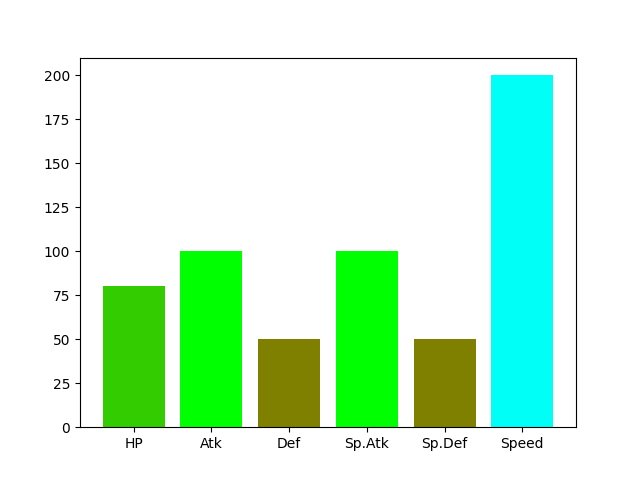
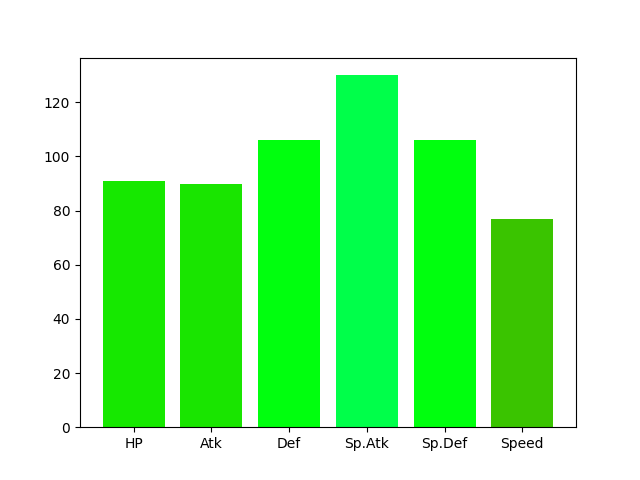
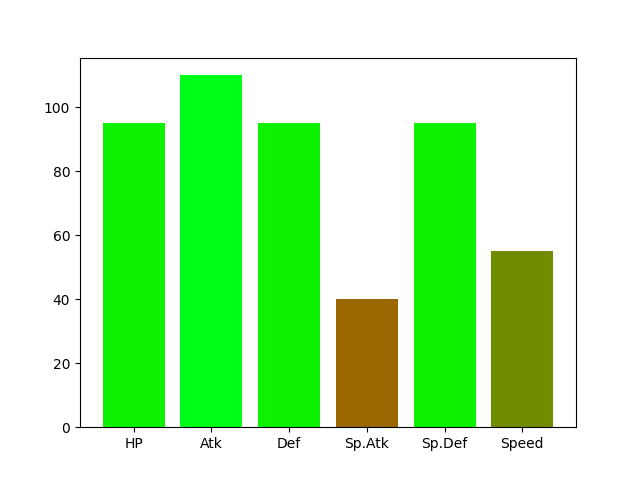
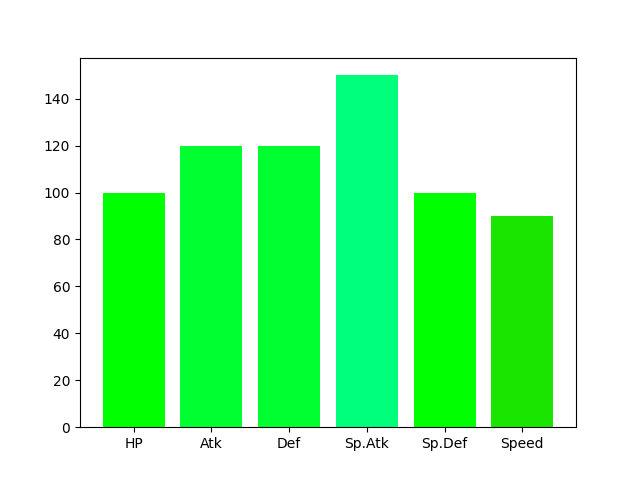
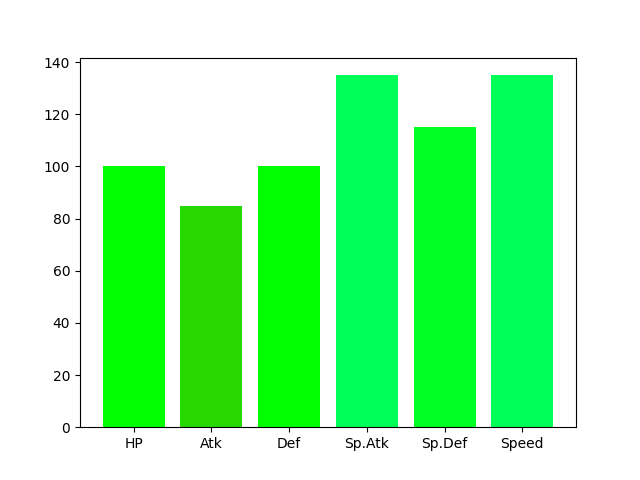
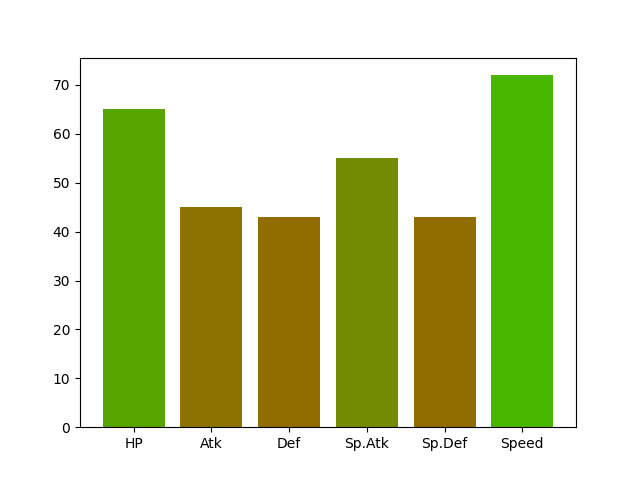

teamScore = 308.76134896527776


#ID,Imagen,Nombre,Tipo,Estadísticas,Atacando frente a tipos,Defendiendo frente a tipos
#894,,Regieleki,['electric'],,"x2: ['water', 'flying']x0.5: ['electric', 'grass', 'ground', 'dragon']","/4: []/2: ['electric', 'flying', 'steel']/0.5: ['ground'] /0.25: []"
#445,,Garchomp,"['dragon', 'ground']",,"x2: ['dragon', 'fire', 'electric', 'poison', 'rock', 'steel']x0.5: ['fairy', 'grass', 'flying', 'bug']","/4: ['electric']/2: ['fire', 'poison', 'rock']/0.5: ['dragon', 'fairy'] /0.25: ['ice']"
#32,,Nidoran-m,['poison'],,"x2: ['grass']x0.5: ['poison', 'ground', 'rock', 'ghost', 'steel']","/4: []/2: ['grass', 'fighting', 'poison', 'bug', 'fairy']/0.5: ['ground', 'psychic'] /0.25: []"
#483,,Dialga,"['steel', 'dragon']",,"x2: ['ice', 'rock', 'fairy', 'dragon']x0.5: ['fire', 'water', 'electric', 'steel', 'steel']","/4: ['grass']/2: ['normal', 'water', 'electric', 'poison', 'flying', 'psychic', 'bug', 'rock', 'ghost', 'dark', 'steel']/0.5: ['fighting', 'ground'] /0.25: []"
#1008,,Miraidon,"['electric', 'dragon']",,"x2: ['water', 'flying', 'dragon']x0.5: ['electric', 'grass', 'ground', 'steel', 'fairy']","/4: ['electric']/2: ['fire', 'water', 'grass', 'flying', 'steel']/0.5: ['ice', 'ground', 'dragon', 'fairy'] /0.25: []"
#990,,Iron-treads,"['ground', 'steel']",,"x2: ['fire', 'electric', 'poison', 'rock', 'steel', 'ice', 'rock', 'fairy']x0.5: ['grass', 'flying', 'bug', 'water']","/4: ['poison', 'rock']/2: ['normal', 'electric', 'flying', 'psychic', 'bug', 'ghost', 'dragon', 'dark', 'steel', 'fairy']/0.5: ['fire', 'water', 'fighting', 'ground'] /0.25: []"

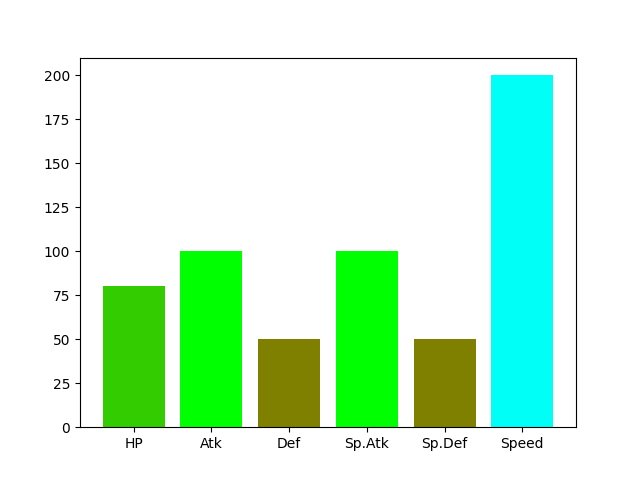
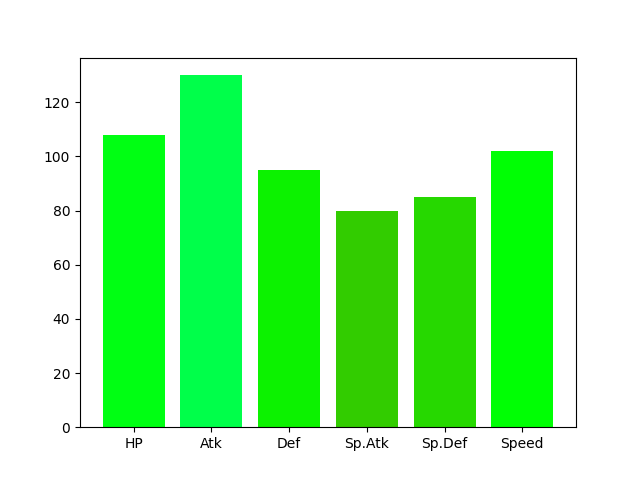
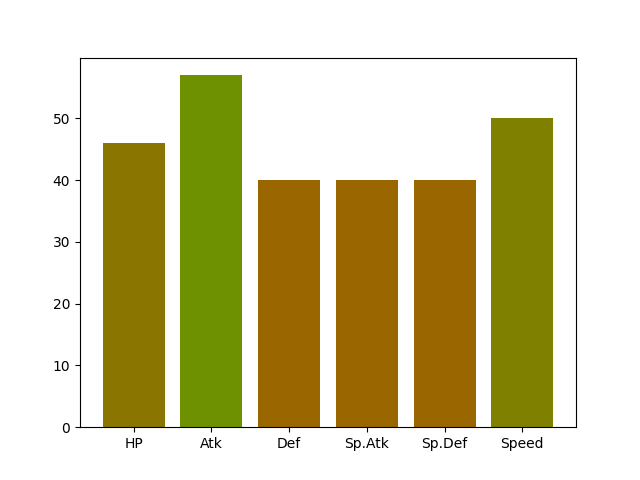
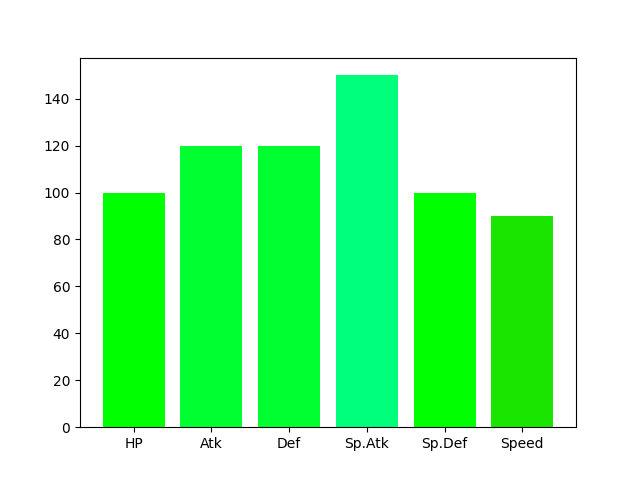
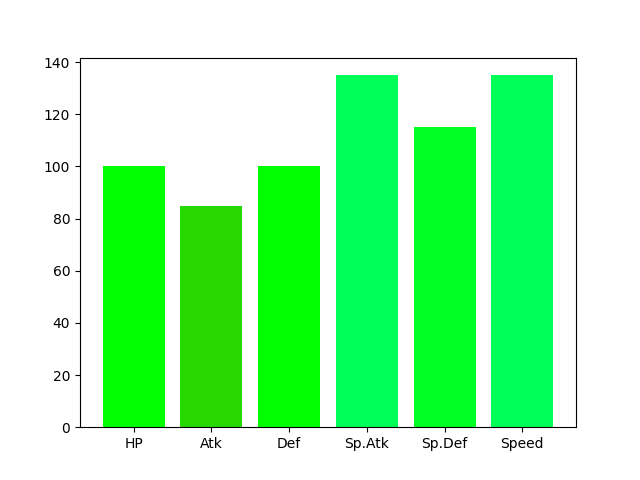
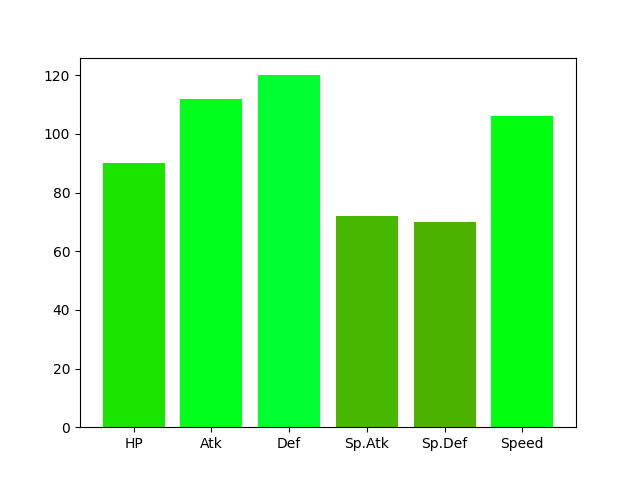

In [56]:
showTeam(population[1])
showTeam(population[2])

In [54]:
population

[[894, 485, 791, 483, 1008, 990],
 [894, 485, 626, 483, 1008, 527],
 [894, 445, 32, 483, 1008, 990],
 [894, 485, 791, 483, 25, 441],
 [894, 4, 791, 606, 1008, 990]]

Muchos supervivientes que quedan son muy parecidos entre sí o tienen algunos genes muy malos al mutar, por lo tanto en el próximo experimento, se va a tratar de mejorar la reproducción, para evitar estos problemas.

## Experimento 2

Se va a implementar una reproducción que emule la reproducción sexual. Cada equipo se cruzará con cada uno del resto de equipos. En este caso la probabilidad de que un gen de un hijo sea de un progenitor u otro es equitativa (un 50%)

In [13]:
def sexual(population:list[list[int]]):
    n_fathers = len(population)

    for i in range(n_fathers):
        father = population[i]

        for j in range (n_fathers):
            mother = population[j]

            if i != j:
                child = []
                for k in range(N):
                    if random.randint(0,1):
                        child.append(mother[k])
                    else:
                        child.append(father[k])
                population.append(child)

teamScore = 229.42958604394735


#ID,Imagen,Nombre,Tipo,Estadísticas,Atacando frente a tipos,Defendiendo frente a tipos
#898,,Calyrex,"['psychic', 'grass']",,"x2: ['fighting', 'poison', 'water', 'ground', 'rock']x0.5: ['psychic', 'dark', 'steel', 'fire', 'grass', 'flying', 'bug', 'dragon', 'steel']","/4: []/2: ['water', 'electric', 'grass', 'fighting', 'ground', 'psychic']/0.5: ['fire', 'ice', 'poison', 'flying', 'ghost', 'dark'] /0.25: ['bug']"
#721,,Volcanion,"['fire', 'water']",,"x2: ['grass', 'ice', 'bug', 'steel', 'fire', 'ground', 'rock']x0.5: ['water', 'dragon', 'water', 'dragon']","/4: ['fire', 'ice', 'steel']/2: ['bug', 'fairy']/0.5: ['electric', 'ground', 'rock'] /0.25: []"
#910,,Crocalor,['fire'],,"x2: ['grass', 'ice', 'bug', 'steel']x0.5: ['fire', 'water', 'rock', 'dragon']","/4: []/2: ['fire', 'grass', 'ice', 'bug', 'steel', 'fairy']/0.5: ['water', 'ground', 'rock'] /0.25: []"
#135,,Jolteon,['electric'],,"x2: ['water', 'flying']x0.5: ['electric', 'grass', 'ground', 'dragon']","/4: []/2: ['electric', 'flying', 'steel']/0.5: ['ground'] /0.25: []"
#1017,,Ogerpon,['grass'],,"x2: ['water', 'ground', 'rock']x0.5: ['fire', 'grass', 'poison', 'flying', 'bug', 'dragon', 'steel']","/4: []/2: ['water', 'electric', 'grass', 'ground']/0.5: ['fire', 'ice', 'poison', 'flying', 'bug'] /0.25: []"
#250,,Ho-oh,"['fire', 'flying']",,"x2: ['grass', 'ice', 'bug', 'steel', 'grass', 'fighting', 'bug']x0.5: ['fire', 'water', 'rock', 'dragon', 'electric', 'rock']","/4: ['grass', 'bug']/2: ['fire', 'fighting', 'steel', 'fairy']/0.5: ['water', 'electric'] /0.25: ['rock']"

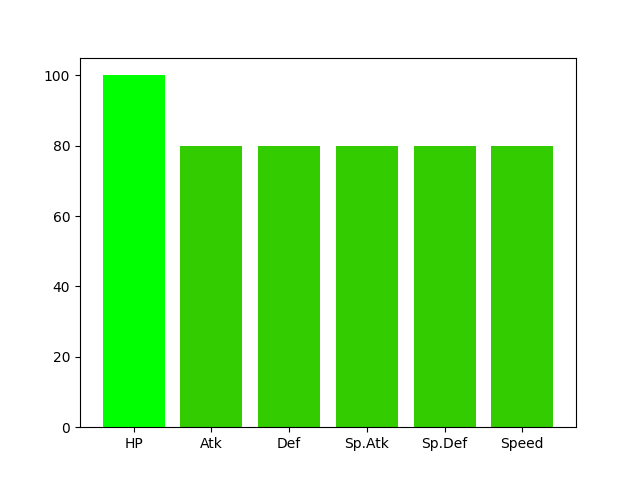
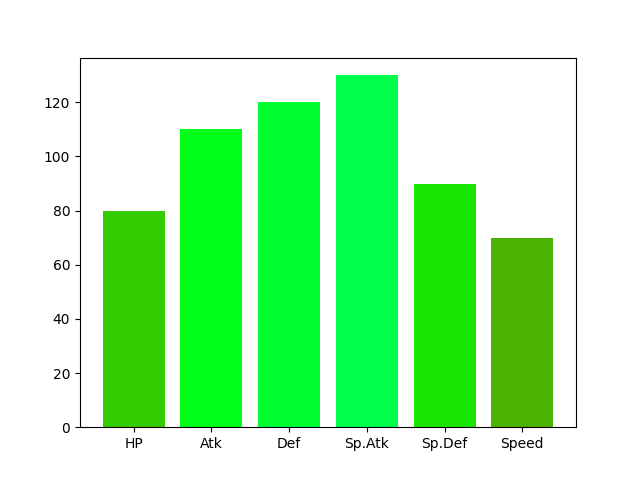
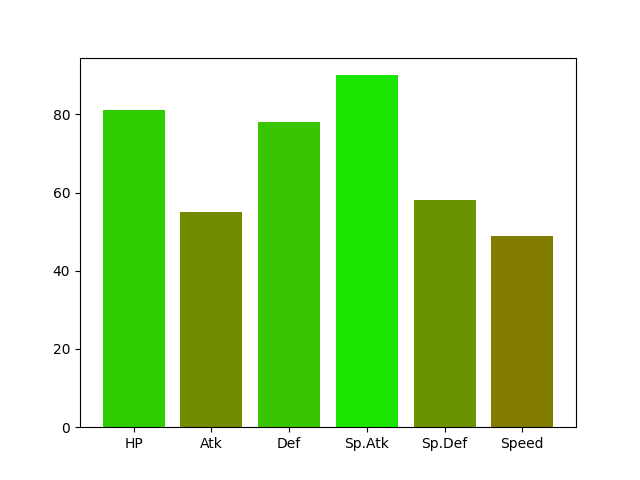
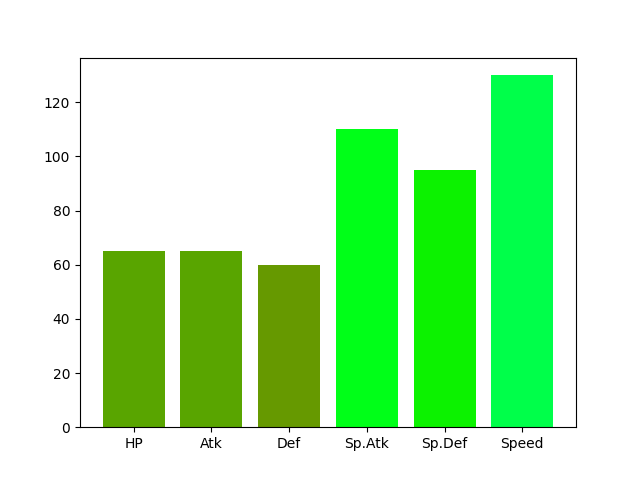
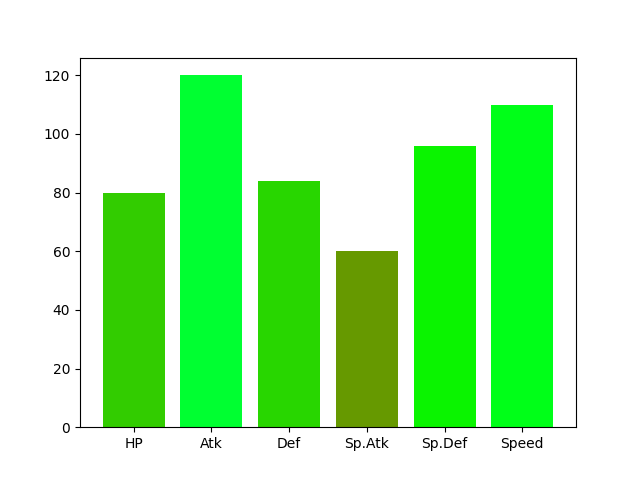
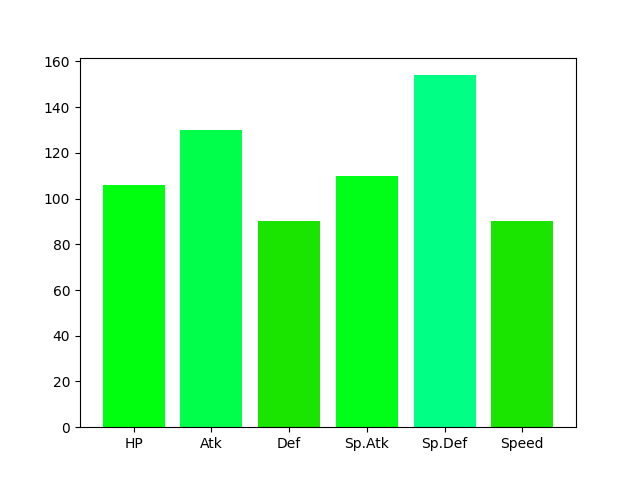

Teams,Scores,Times,Iterations
,190.91151711435484,1.543738,1
,208.09079204304157,9.478634,2
,221.55699629819097,16.14517,3
,223.10542345623367,22.712237,4
,229.42958604394735,32.031069,6


In [16]:
reproduce = sexual

mutate = mutate_random_rate
mutatation_rate = 0.1

remove = survive_the_best
survivors = 4

stop_condition = stop_by_time
seconds = 30

N = 6
D = 1024

population = [[1,1,1, 1,1,1],[1,1,1, 1,1,1]]
experiment = run_genetic(population)

showTeam(best_team)
experiment.showTable()


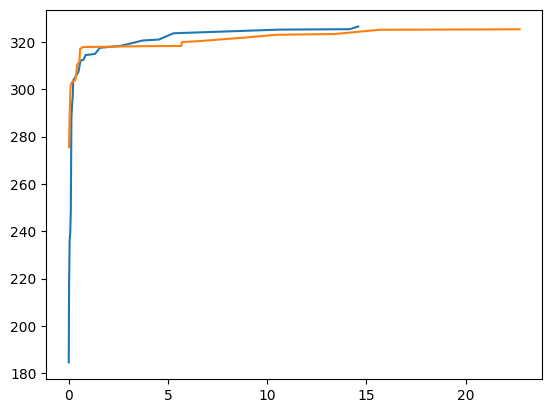

In [70]:
plt.plot(experiment.times, experiment.scores, label="sexual")
plt.plot(experiment2.times, experiment2.scores, label="clone")
plt.show()

teamScore = 325.35315023055523


#ID,Imagen,Nombre,Tipo,Estadísticas,Atacando frente a tipos,Defendiendo frente a tipos
#483,,Dialga,"['steel', 'dragon']",,"x2: ['ice', 'rock', 'fairy', 'dragon']x0.5: ['fire', 'water', 'electric', 'steel', 'steel']","/4: ['grass']/2: ['normal', 'water', 'electric', 'poison', 'flying', 'psychic', 'bug', 'rock', 'ghost', 'dark', 'steel']/0.5: ['fighting', 'ground'] /0.25: []"
#485,,Heatran,"['fire', 'steel']",,"x2: ['grass', 'ice', 'bug', 'steel', 'ice', 'rock', 'fairy']x0.5: ['fire', 'water', 'dragon', 'fire', 'water', 'electric']","/4: ['grass', 'ice', 'bug', 'steel', 'fairy']/2: ['normal', 'poison', 'flying', 'psychic', 'ghost', 'dragon', 'dark']/0.5: ['water', 'fighting'] /0.25: ['ground']"
#894,,Regieleki,['electric'],,"x2: ['water', 'flying']x0.5: ['electric', 'grass', 'ground', 'dragon']","/4: []/2: ['electric', 'flying', 'steel']/0.5: ['ground'] /0.25: []"
#801,,Magearna,"['steel', 'fairy']",,"x2: ['ice', 'rock', 'fairy', 'fighting', 'dragon', 'dark']x0.5: ['fire', 'water', 'electric', 'steel', 'fire', 'poison', 'steel']","/4: ['bug', 'dragon', 'dark']/2: ['normal', 'grass', 'ice', 'poison', 'flying', 'psychic', 'rock', 'ghost', 'fairy']/0.5: ['fire', 'ground'] /0.25: []"
#890,,Eternatus,"['poison', 'dragon']",,"x2: ['grass', 'dragon']x0.5: ['poison', 'ground', 'rock', 'ghost', 'steel', 'steel', 'fairy']","/4: ['grass']/2: ['fire', 'water', 'electric', 'fighting', 'poison', 'bug']/0.5: ['ice', 'ground', 'psychic', 'dragon'] /0.25: []"
#792,,Lunala,"['psychic', 'ghost']",,"x2: ['fighting', 'poison', 'psychic', 'ghost']x0.5: ['dark', 'steel', 'normal', 'dark', 'steel']","/4: ['fighting']/2: ['normal', 'poison', 'psychic']/0.5: [] /0.25: ['ghost', 'dark']"

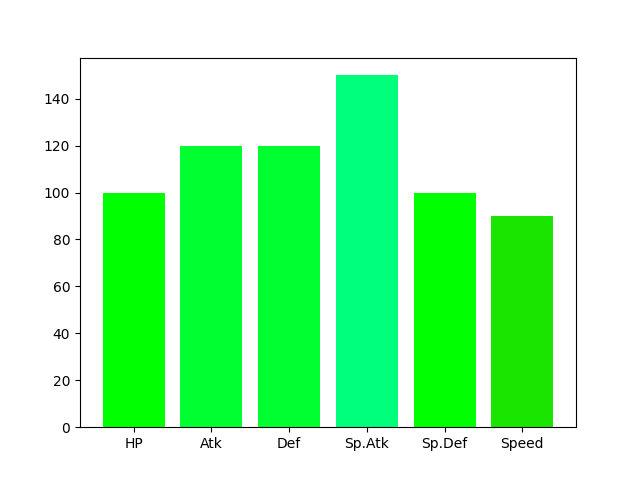
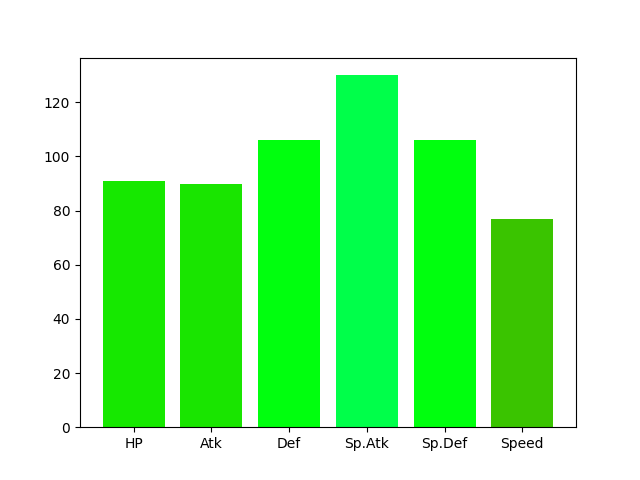
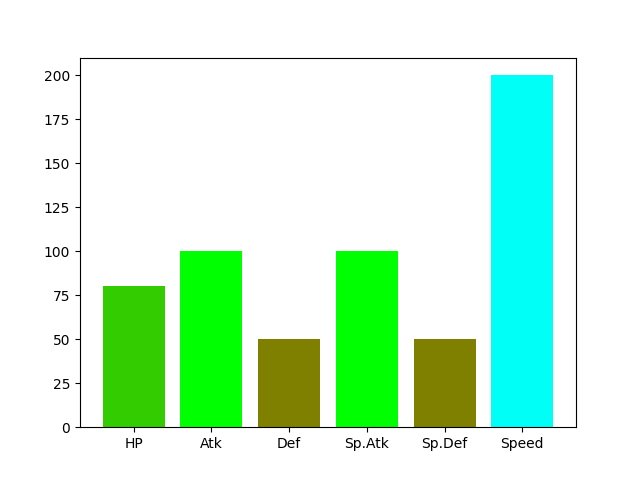
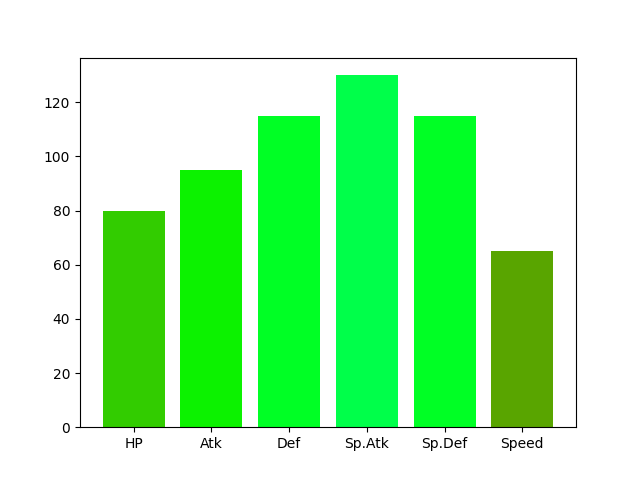
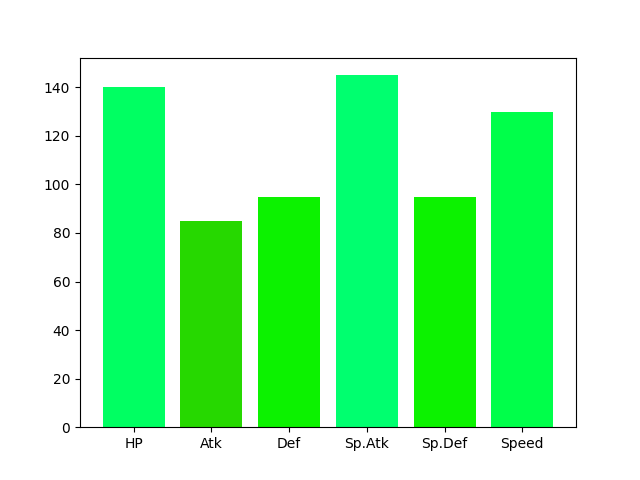
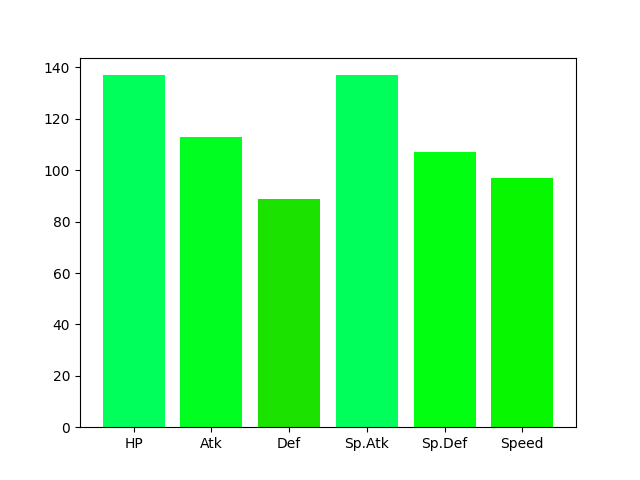

Teams,Scores,Times,Iterations
,184.54701404914167,0.003997,1
,216.9700609650571,0.019338,2
,226.44861319741815,0.034413,3
,236.48730411549883,0.048824,4
,237.8673456342832,0.063339,5
,239.34568967677495,0.07742,6
,248.95791842635103,0.107639,8
,288.13156503694705,0.136857,10
,294.36843539273667,0.179673,13
,297.77562579611214,0.209808,15


In [69]:
reproduce = cloning
copies = 4


mutate = mutate_random_rate
mutatation_rate = 0.1

remove = survive_the_best
survivors = 4

stop_condition = stop_by_time
seconds = 30

N = 6
D = 1024

population = [[1,1,1, 1,1,1],[1,1,1, 1,1,1]]
experiment2 = run_genetic(population)

showTeam(best_team)
experiment.showTable()

In [75]:
seconds = 600

experiment1 = run_genetic([[1,1,1, 1,1,1], [1,1,1, 1,1,1]])
experiment2.showTable()

reproduce = cloning
copies = 4
experiment2 = run_genetic([[1,1,1, 1,1,1], [1,1,1, 1,1,1]])
experiment2.showTable()

Teams,Scores,Times,Iterations
,275.5233242328771,0.013251,1
,289.71633438330764,0.050502,3
,300.1366031295174,0.087182,5
,301.9719497226004,0.1055,6
,303.6032994560698,0.216432,12
,303.84854107247816,0.332395,18
,306.02938983118025,0.369026,20
,310.27317617674214,0.425992,23
,311.64629348750697,0.539165,29
,317.060098521166,0.574858,31


Teams,Scores,Times,Iterations
,171.05790981458009,0.009985,1
,217.55365051688966,0.028083,2
,243.06620467916815,0.046761,3
,245.37650629342332,0.069985,4
,252.72558546408445,0.088989,5
,258.2575570399872,0.12713,7
,261.2195858356471,0.202011,11
,263.1770264241301,0.334962,18
,299.0536663089711,0.750648,40
,302.61134938643863,0.807746,43


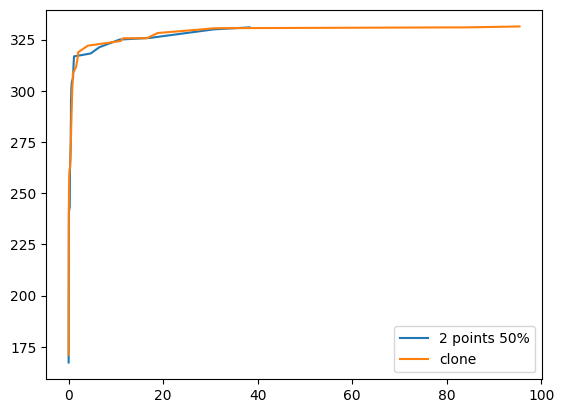

In [82]:
plt.plot(experiment1.times, experiment1.scores, label="2 points 50%")
plt.plot(experiment2.times, experiment2.scores, label="clone")
plt.legend()
plt.show()

A partir de 40 segundos el nuevo método de reproducción no da mejoras.

In [88]:
seconds = 5

N = 20
experiment1 = run_genetic([[1]*20, [1]*20])
experiment1.showTable()

reproduce = sexual
experiment2 = run_genetic([[1]*20, [1]*20])
experiment2.showTable()

Teams,Scores,Times,Iterations
,255.77918862450895,0.01,1
,277.4966642348222,0.047374,2
,298.12482539203495,0.083872,3
,298.4647887866556,0.121829,4
,303.0797837765468,0.158576,5
,308.4718250999035,0.231292,7
,309.65773613894265,0.377496,11
,310.7395646507494,0.413828,12
,311.22136652293966,0.486324,14
,313.4162155917046,0.63463,18


Teams,Scores,Times,Iterations
,256.57379163477776,0.010515,1
,286.7496554266911,0.049899,2
,292.24070767500945,0.094179,3
,306.5086510021828,0.138335,4
,346.89843585236076,0.177777,5
,348.50521674622735,0.369926,10
,354.22232832253104,0.444683,12
,357.4347776455386,0.482937,13
,366.7121624634565,0.520512,14
,371.0703282526266,0.857946,23


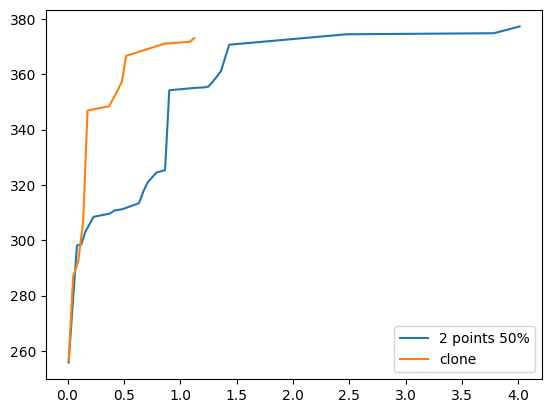

In [89]:
plt.plot(experiment1.times, experiment1.scores, label="2 points 50%")
plt.plot(experiment2.times, experiment2.scores, label="clone")
plt.legend()
plt.show()

teamScore = 373.1359243576478


#ID,Imagen,Nombre,Tipo,Estadísticas,Atacando frente a tipos,Defendiendo frente a tipos
#1005,,Roaring-moon,"['dragon', 'dark']",,"x2: ['dragon', 'psychic', 'ghost']x0.5: ['steel', 'fairy', 'fighting', 'dark', 'steel', 'fairy']","/4: []/2: ['fire', 'water', 'electric', 'grass', 'psychic', 'ghost', 'dark']/0.5: ['ice', 'fighting', 'bug', 'dragon'] /0.25: ['fairy']"
#821,,Rookidee,['flying'],,"x2: ['grass', 'fighting', 'bug']x0.5: ['electric', 'rock', 'steel']","/4: []/2: ['grass', 'fighting', 'ground', 'bug']/0.5: ['electric', 'ice', 'rock'] /0.25: []"
#376,,Metagross,"['steel', 'psychic']",,"x2: ['ice', 'rock', 'fairy', 'fighting', 'poison']x0.5: ['fire', 'water', 'electric', 'steel', 'psychic', 'dark', 'steel']","/4: ['psychic']/2: ['normal', 'grass', 'ice', 'poison', 'flying', 'rock', 'dragon', 'steel', 'fairy']/0.5: ['fire', 'ground'] /0.25: []"
#798,,Kartana,"['grass', 'steel']",,"x2: ['water', 'ground', 'rock', 'ice', 'rock', 'fairy']x0.5: ['fire', 'grass', 'poison', 'flying', 'bug', 'dragon', 'steel', 'fire', 'electric', 'steel']","/4: ['grass']/2: ['normal', 'water', 'electric', 'psychic', 'rock', 'ghost', 'dragon', 'dark', 'steel', 'fairy']/0.5: ['fighting'] /0.25: ['fire']"
#250,,Ho-oh,"['fire', 'flying']",,"x2: ['grass', 'ice', 'bug', 'steel', 'grass', 'fighting', 'bug']x0.5: ['fire', 'water', 'rock', 'dragon', 'electric', 'rock']","/4: ['grass', 'bug']/2: ['fire', 'fighting', 'steel', 'fairy']/0.5: ['water', 'electric'] /0.25: ['rock']"
#894,,Regieleki,['electric'],,"x2: ['water', 'flying']x0.5: ['electric', 'grass', 'ground', 'dragon']","/4: []/2: ['electric', 'flying', 'steel']/0.5: ['ground'] /0.25: []"
#450,,Hippowdon,['ground'],,"x2: ['fire', 'electric', 'poison', 'rock', 'steel']x0.5: ['grass', 'flying', 'bug']","/4: []/2: ['electric', 'poison', 'rock']/0.5: ['water', 'grass', 'ice'] /0.25: []"
#357,,Tropius,"['grass', 'flying']",,"x2: ['water', 'ground', 'rock', 'grass', 'fighting', 'bug']x0.5: ['fire', 'poison', 'flying', 'dragon', 'steel', 'electric', 'steel']","/4: ['grass', 'ground']/2: ['water', 'fighting']/0.5: ['fire', 'poison', 'flying', 'rock'] /0.25: ['ice']"
#101,,Electrode,['electric'],,"x2: ['water', 'flying']x0.5: ['electric', 'grass', 'ground', 'dragon']","/4: []/2: ['electric', 'flying', 'steel']/0.5: ['ground'] /0.25: []"
#689,,Barbaracle,"['rock', 'water']",,"x2: ['fire', 'ice', 'flying', 'bug', 'fire', 'ground', 'rock']x0.5: ['fighting', 'steel', 'water', 'grass', 'dragon']","/4: ['fire']/2: ['normal', 'ice', 'poison', 'flying']/0.5: ['electric', 'fighting', 'ground'] /0.25: ['grass']"

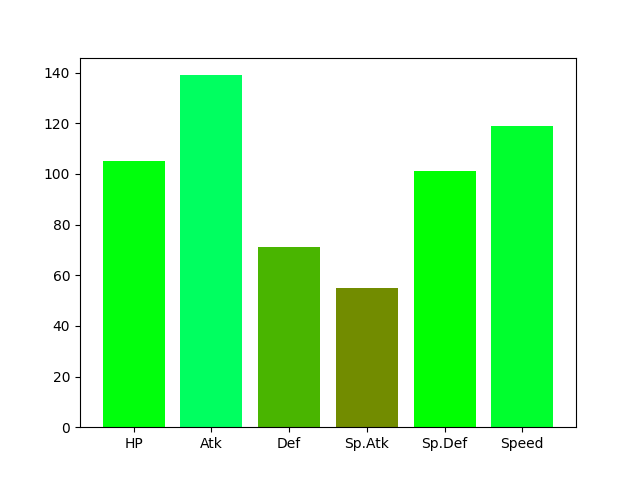
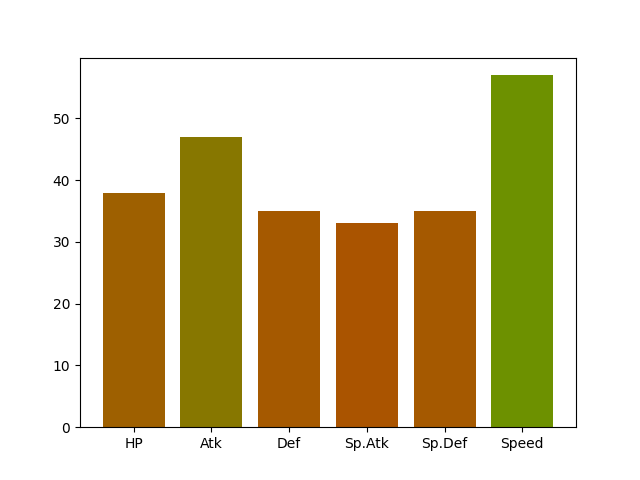
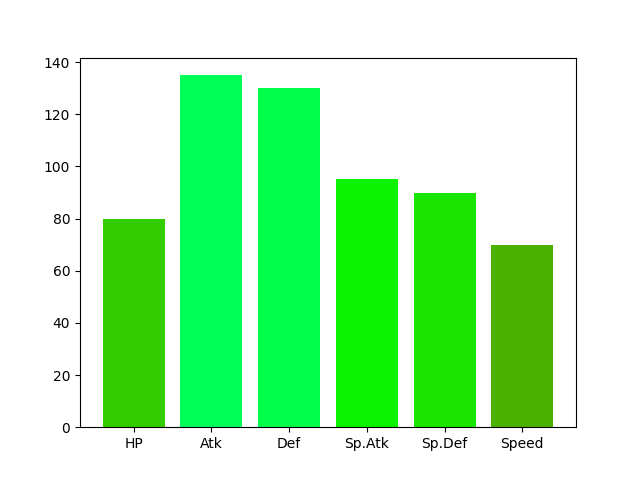
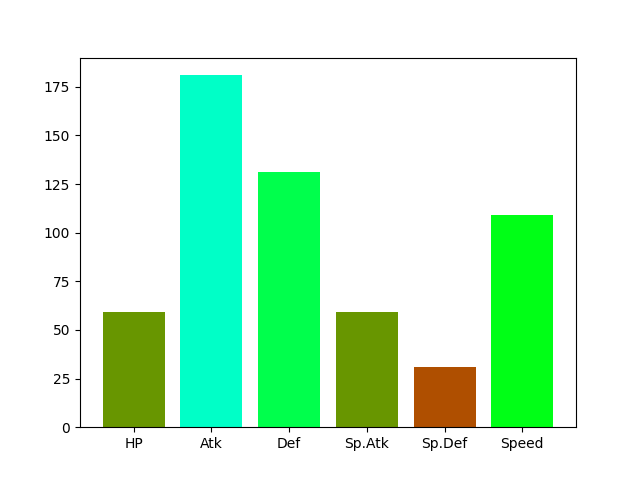
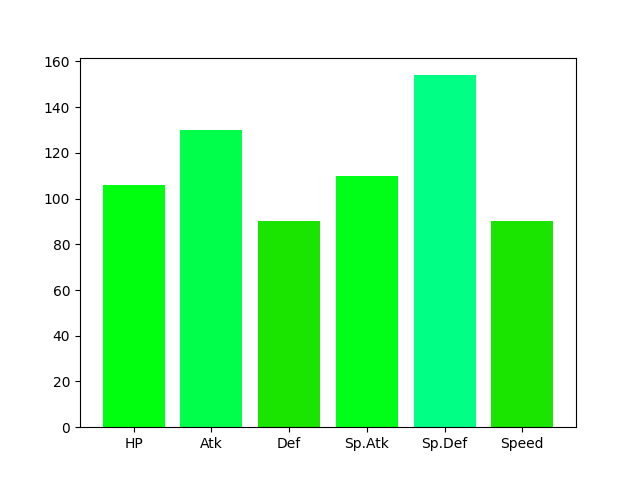
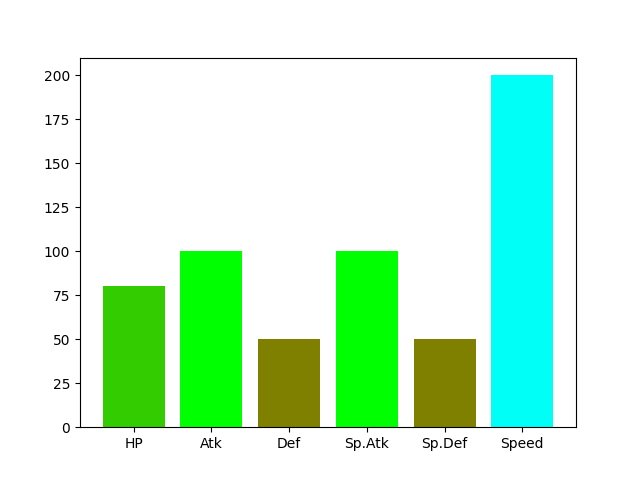
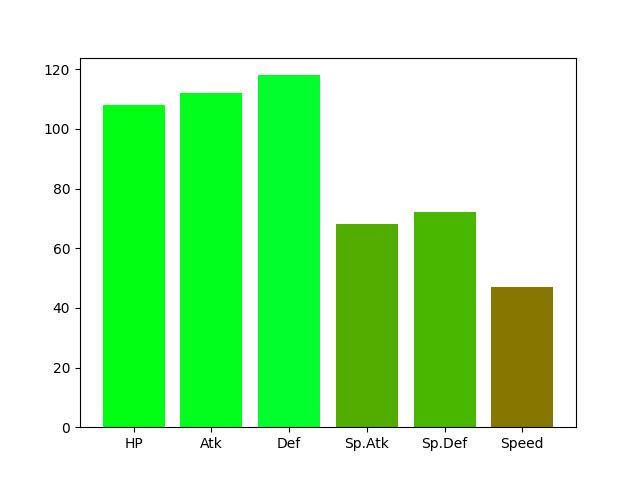
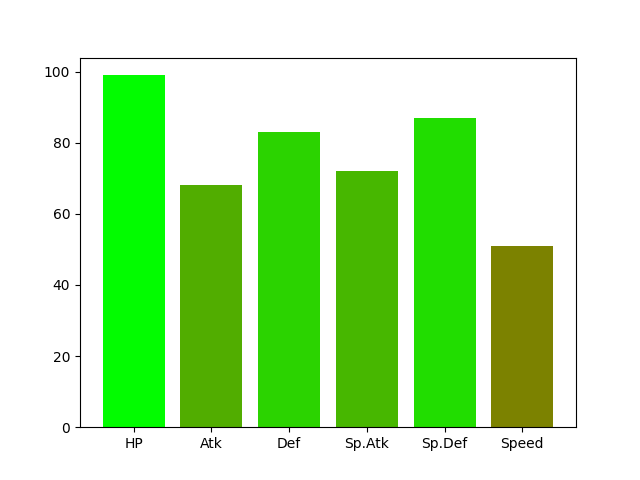
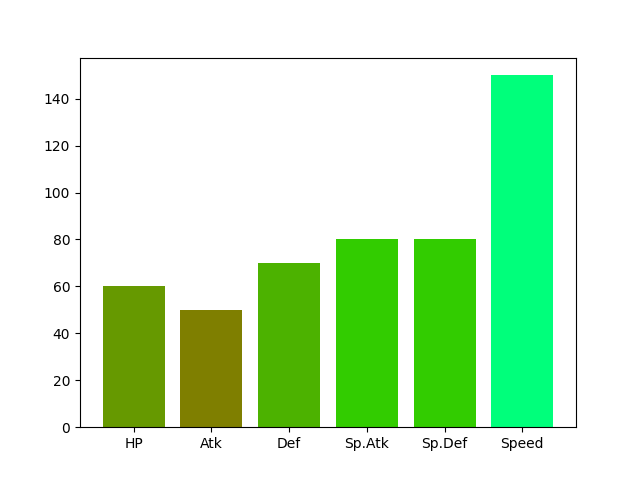
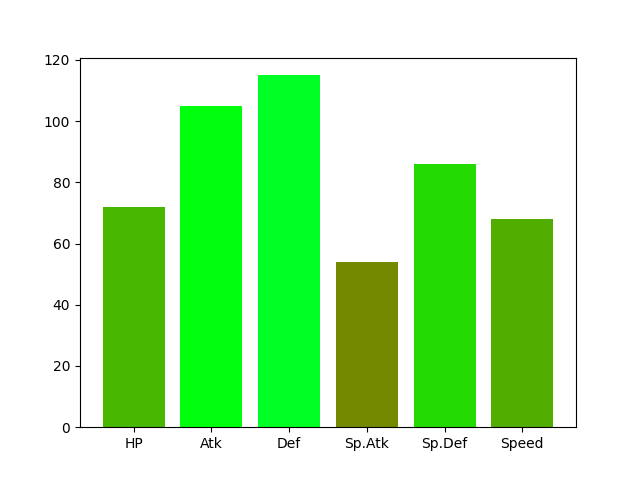
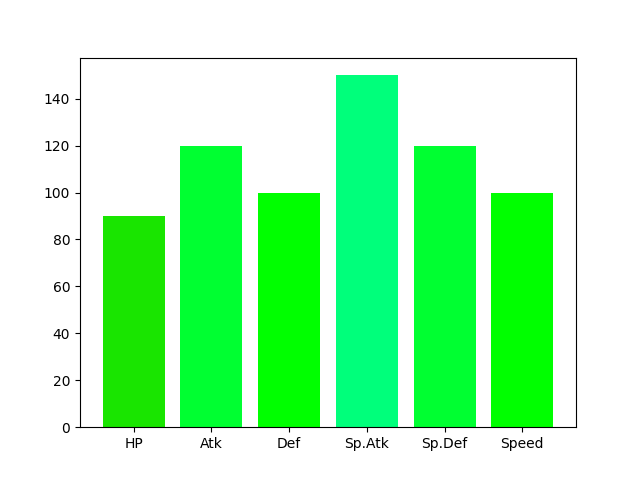
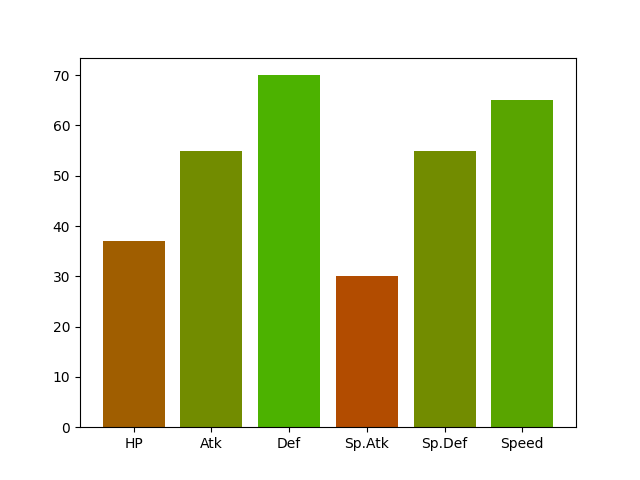
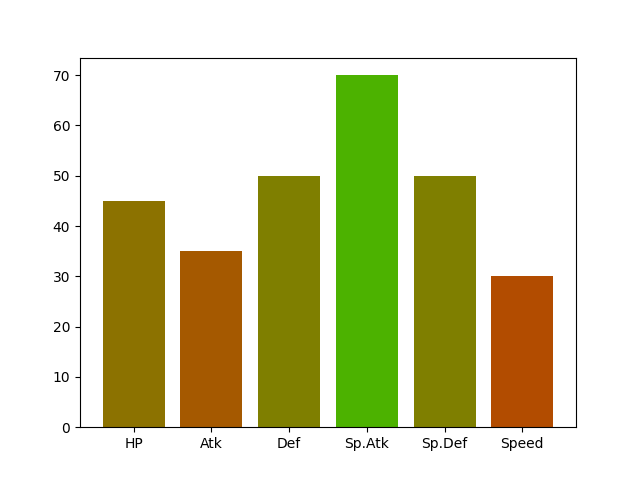
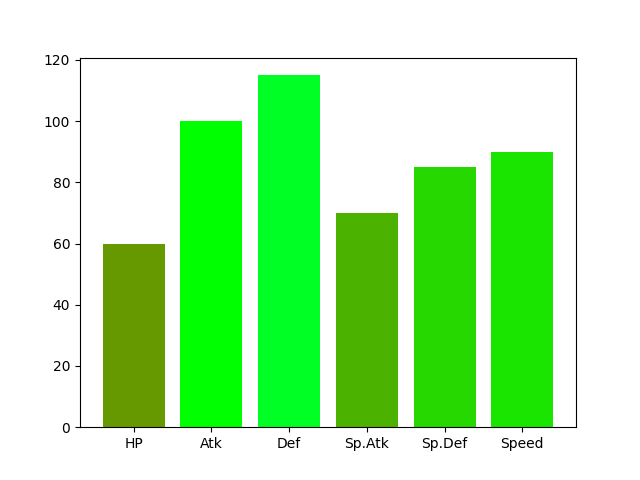
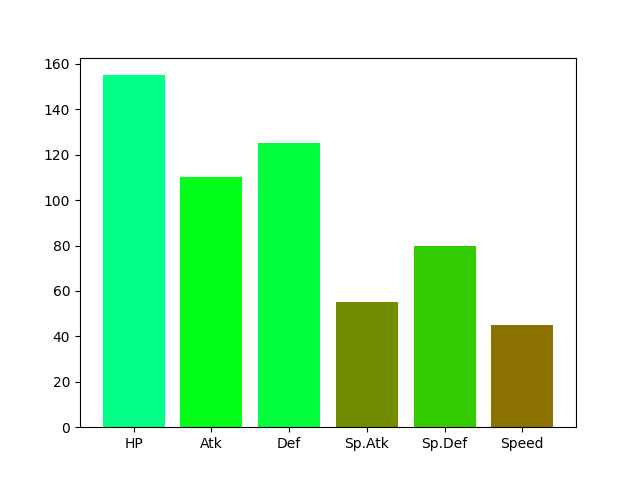
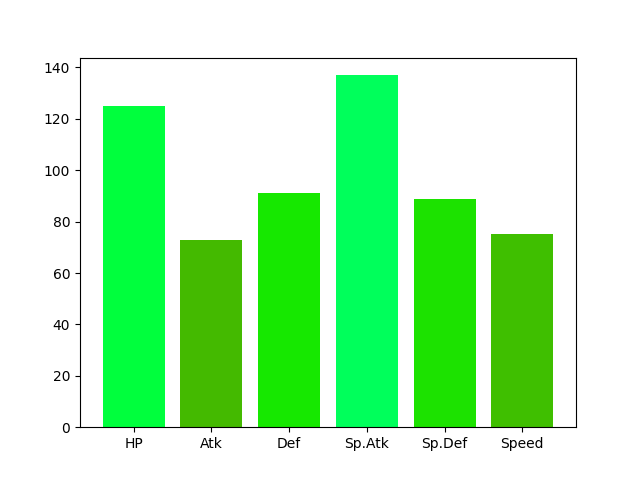
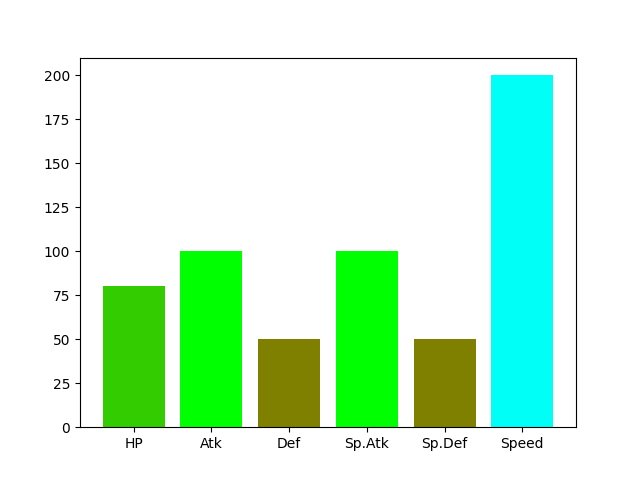
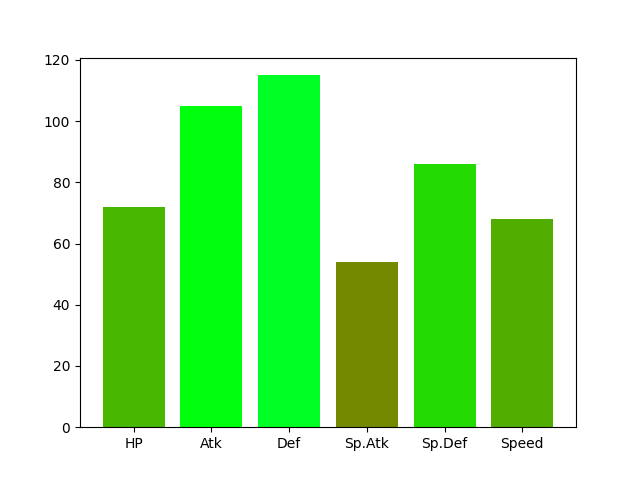
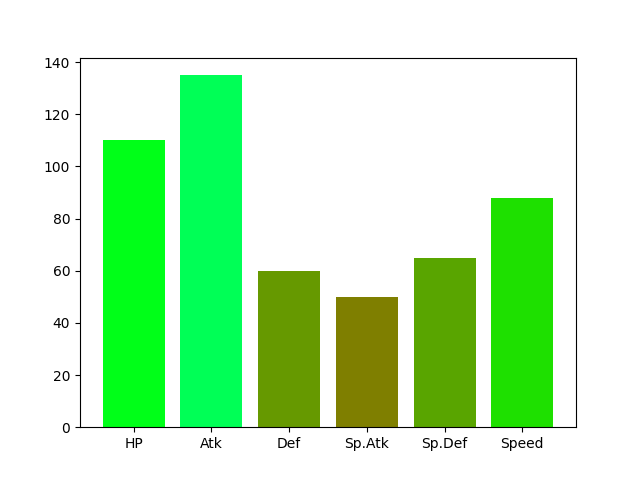
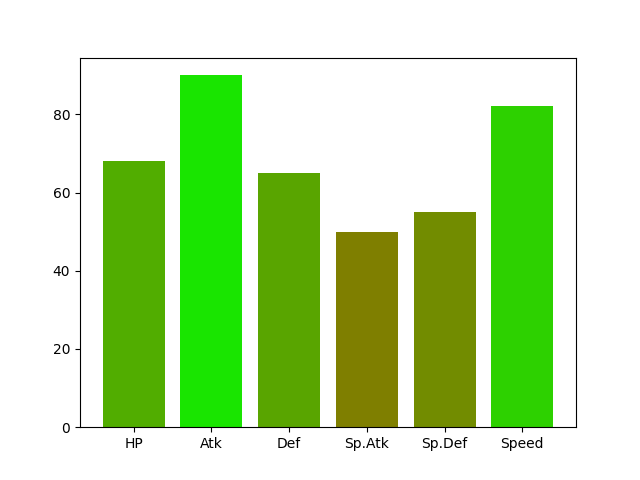

In [90]:
showTeam(best_team)

En primera instancia sorprende que la mejor puntación se alcance antes al aumentar la talla de pokemons. Pero como podemos observar, la solución es mejorable, ya que hay muchos pokemon pueden ser mejores, pero hay pokemons muy buenos, hace que sus estadisticas cuenten muy poco porque tienen bajo rango. Por tanto una posible solución es hacer que muten mucho.

In [91]:
population

[[483, 485, 894, 801, 890, 792],
 [619, 485, 894, 950, 890, 792],
 [966, 485, 894, 345, 890, 286],
 [502, 485, 894, 909, 890, 792]]